In [ ]:
!apt-get install swig
!pip install gymnasium[box2d]
!pip install moviepy
!pip install moviepy --quiet
!pip install gym matplotlib ipywidgets --quiet
!pip uninstall numpy -y
!pip install numpy==1.23.5
from moviepy.editor import VideoClip
from IPython.display import Video, display


import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from moviepy.editor import concatenate_videoclips
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from tqdm import tqdm

import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_video(frames, video_path, fps=30):
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(video_path, codec="libx264")

    display(Video(video_path, embed=True))

In [3]:
def plot_reward(episode_rewards, agent_name = 'Agent'):
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"Mean Reward: {mean_reward:.2f}")
    print(f"Standard Deviation of Reward: {std_reward:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    ax1.hist(episode_rewards, bins=20, color='skyblue', edgecolor='black')
    ax1.set_title("Total Reward distribution")
    ax1.set_xlabel("total Reward")
    ax1.set_ylabel("Frequence")
    ax1.grid()

    ax2.plot(episode_rewards)
    ax2.set_title("Total Reward over episodes")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Total Reward")
    fig.suptitle(agent_name);
    plt.show()


def calculate_cumulative_average(rewards, name_for_plot = None):
    cumulative_average = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)

    if name_for_plot is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_average, color="C1")
        plt.title(f"Mean Cumulative Reward [{name_for_plot}]")
        plt.xlabel("Episode")
        plt.legend()
        plt.grid()

    return cumulative_average

# Environment Exploration

In [4]:
env = gym.make("LunarLander-v2")

First we show information about the observation and action space to understand the environment better.

In [5]:
print("Observation Space:")
dimensions = [
    "Horizontal Coordinate (x position)",
    "Vertical Coordinate (y position)",
    "Horizontal Speed (x velocity)",
    "Vertical Speed (y velocity)",
    "Angle (rotation)",
    "Angular Speed (rotation velocity)",
    "Left Leg Contact (binary)",
    "Right Leg Contact (binary)"
]

for i, (low, high, label) in enumerate(zip(env.observation_space.low, env.observation_space.high, dimensions)):
    print(f"Dimension {i+1}: {label}")
    print(f"  Range: [{low}, {high}]\n")

print("\nAction Space:")
actions = {
        0: "Do nothing",
        1: "Fire right engine",
        2: "Fire central engine",
        3: "Fire left engine"}
print(actions)
env.close()

Observation Space:
Dimension 1: Horizontal Coordinate (x position)
  Range: [-1.5, 1.5]

Dimension 2: Vertical Coordinate (y position)
  Range: [-1.5, 1.5]

Dimension 3: Horizontal Speed (x velocity)
  Range: [-5.0, 5.0]

Dimension 4: Vertical Speed (y velocity)
  Range: [-5.0, 5.0]

Dimension 5: Angle (rotation)
  Range: [-3.1415927410125732, 3.1415927410125732]

Dimension 6: Angular Speed (rotation velocity)
  Range: [-5.0, 5.0]

Dimension 7: Left Leg Contact (binary)
  Range: [-0.0, 1.0]

Dimension 8: Right Leg Contact (binary)
  Range: [-0.0, 1.0]


Action Space:
{0: 'Do nothing', 1: 'Fire right engine', 2: 'Fire central engine', 3: 'Fire left engine'}


Next we visualize our lander by running one episode for each of the possible actions it can do. During the entirety of that episode the robot will be able to do only that.

In [6]:
def annotate_frames(frames, action_id):
    annotated_frames = []
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        y_offset = 30
        for a_id, action_text in actions.items():
            status = "ON" if a_id == action_id else "OFF"
            text = f"{action_text}: {status}"
            cv2.putText(
                frame_bgr, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA
            )
            y_offset += 20

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        annotated_frames.append(frame_rgb)
    return annotated_frames

In [7]:
def simulate_episode_with_observations(action_id, action_text):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    frames = []
    observations = []
    obs = env.reset()

    for _ in range(500):
        frame = env.render()
        frames.append(np.squeeze(frame))
        observations.append(obs)
        obs, reward, done, info = env.step(action_id)
        if done:
            break

    env.close()
    return frames, np.array(observations)


all_frames = {}
all_observations = {}

for action_id, action_text in actions.items():
    frames, observations = simulate_episode_with_observations(action_id, action_text)
    all_frames[action_id] = frames
    all_observations[action_id] = observations


all_annotated_frames = []
for action_id, action_text in actions.items():
    annotated_frames = annotate_frames(all_frames[action_id], action_id)
    all_annotated_frames.extend(annotated_frames)
    all_annotated_frames.extend([np.zeros_like(annotated_frames[0])] * 10)


create_video(all_annotated_frames, "lunar_lander_all_actions_annotated.mp4")

Moviepy - Building video lunar_lander_all_actions_annotated.mp4.
Moviepy - Writing video lunar_lander_all_actions_annotated.mp4



Moviepy - Done !
Moviepy - video ready lunar_lander_all_actions_annotated.mp4


It's important that the lander starts to balance the actions in order to reach the area correctly.

# Random Agent

In [8]:
def simulate_episodes(num_episodes=100, max_steps=500):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    episode_rewards = []
    step_rewards = []
    episodes_data = []

    for episode in range(num_episodes):
        obs = env.reset()
        total_reward = 0
        rewards_per_episode = []
        episode_frames = []

        for _ in range(max_steps):
            frame = env.render()
            episode_frames.append(np.squeeze(frame))

            action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            # reward is ignored
            total_reward += reward
            rewards_per_episode.append(reward)

            if done:
                break

        episode_rewards.append(total_reward)
        step_rewards.append(rewards_per_episode)
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}")
        episodes_data.append({"frames": episode_frames, "reward": total_reward})

    return episode_rewards, step_rewards, episodes_data


random_agent_episode_rewards, random_agent_step_rewards, random_agent_data = simulate_episodes(num_episodes=100)

Episode 1/100: Total Reward = -124.01
Episode 2/100: Total Reward = -124.56
Episode 3/100: Total Reward = -108.95
Episode 4/100: Total Reward = -154.64
Episode 5/100: Total Reward = -190.23
Episode 6/100: Total Reward = -136.85
Episode 7/100: Total Reward = -339.83
Episode 8/100: Total Reward = -416.93
Episode 9/100: Total Reward = -300.65
Episode 10/100: Total Reward = -152.92
Episode 11/100: Total Reward = -81.61
Episode 12/100: Total Reward = -259.07
Episode 13/100: Total Reward = -155.12
Episode 14/100: Total Reward = -262.85
Episode 15/100: Total Reward = -187.11
Episode 16/100: Total Reward = -498.43
Episode 17/100: Total Reward = -343.11
Episode 18/100: Total Reward = -151.34
Episode 19/100: Total Reward = -112.65
Episode 20/100: Total Reward = -154.64
Episode 21/100: Total Reward = -118.64
Episode 22/100: Total Reward = -119.18
Episode 23/100: Total Reward = -245.88
Episode 24/100: Total Reward = -129.22
Episode 25/100: Total Reward = -119.46
Episode 26/100: Total Reward = -143

In [9]:
create_video(random_agent_data[0]["frames"], video_path="random_agent.mp4")

Moviepy - Building video random_agent.mp4.
Moviepy - Writing video random_agent.mp4



Moviepy - Done !
Moviepy - video ready random_agent.mp4


In RL to evaluate a training we should plot the reward evolution.
We'll also look at the distribution.

Mean Reward: -193.78
Standard Deviation of Reward: 98.02


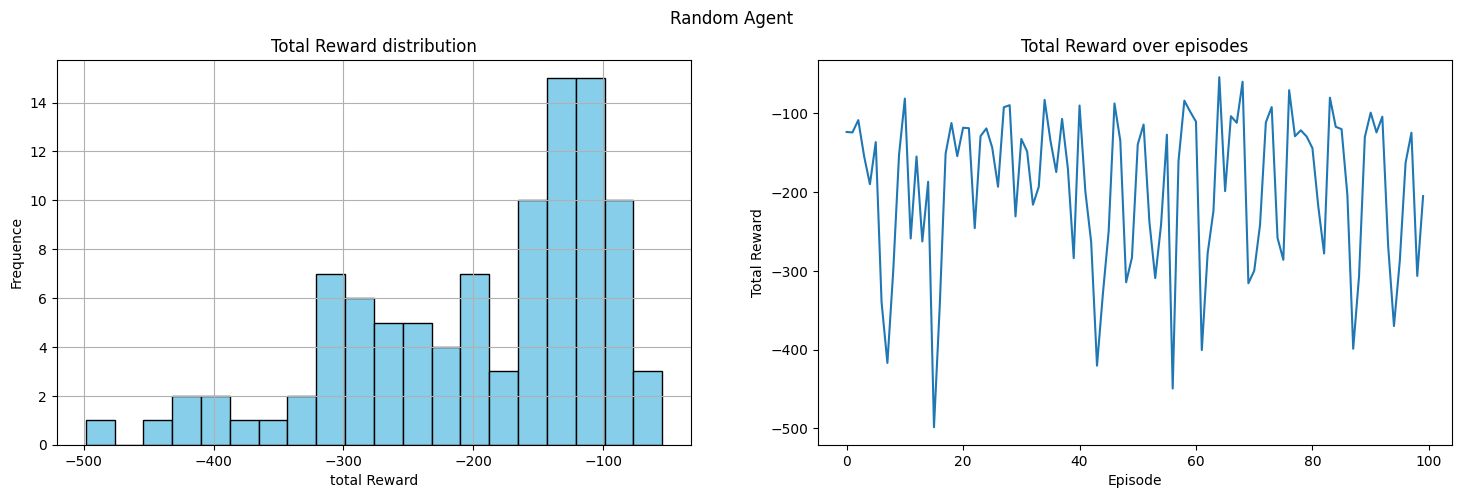

In [10]:
plot_reward(random_agent_episode_rewards, "Random Agent")

Clearly the random agent doesn't have a good reward distribution, and the episode plot looks like noise. This makes seanse since the agent is ignoring the reward and taking random actions, we won't see any patterns.

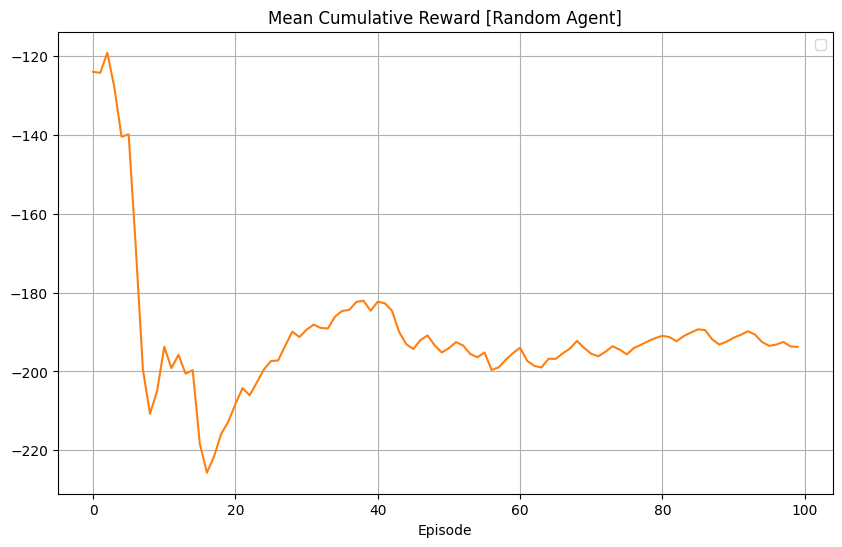

In [11]:
cumulative_average_rewards_random = calculate_cumulative_average(random_agent_episode_rewards, "Random Agent")

The cumulative reward plot looks okay, but the reward would never get much either and set on a plateau.

# Accounting Agent


We implement a naive agent that has a simple memory: it will remember which action lead to higher rewards, and choose the best action with argmax.

In [12]:
class AccountingAgent:
    def __init__(self, num_actions):
        self.action_rewards = np.zeros(num_actions)

    # it chooses the action with the current max reward
    def choose_action(self):
        return np.argmax(self.action_rewards)

    def update_rewards(self, action, reward):
        self.action_rewards[action] += reward

In [13]:
def simulate_accounting_agent(num_episodes=1000, max_steps=500):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    agent = AccountingAgent(env.action_space.n)
    episode_rewards = []
    step_rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        total_reward = 0
        rewards_per_episode = []

        for _ in range(max_steps):
            action = agent.choose_action()
            obs, reward, done, info = env.step(action)
            total_reward += reward
            rewards_per_episode.append(reward)


            agent.update_rewards(action, reward)

            if done:
                break

        episode_rewards.append(total_reward)
        step_rewards.append(rewards_per_episode)
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}")

    return episode_rewards, step_rewards

In [15]:
accounting_agent_episode_rewards, accounting_agent_step_rewards= simulate_accounting_agent(num_episodes=1000)

Episode 1/1000: Total Reward = -344.69
Episode 2/1000: Total Reward = -238.99
Episode 3/1000: Total Reward = -541.61
Episode 4/1000: Total Reward = -476.80
Episode 5/1000: Total Reward = -115.66
Episode 6/1000: Total Reward = -365.30
Episode 7/1000: Total Reward = -602.08
Episode 8/1000: Total Reward = -416.95
Episode 9/1000: Total Reward = 17.11
Episode 10/1000: Total Reward = -543.04
Episode 11/1000: Total Reward = -164.94
Episode 12/1000: Total Reward = -453.45
Episode 13/1000: Total Reward = -449.50
Episode 14/1000: Total Reward = -517.54
Episode 15/1000: Total Reward = -145.84
Episode 16/1000: Total Reward = -463.19
Episode 17/1000: Total Reward = -459.44
Episode 18/1000: Total Reward = -357.58
Episode 19/1000: Total Reward = -561.10
Episode 20/1000: Total Reward = -138.29
Episode 21/1000: Total Reward = -505.25
Episode 22/1000: Total Reward = -136.44
Episode 23/1000: Total Reward = -343.61
Episode 24/1000: Total Reward = -67.56
Episode 25/1000: Total Reward = -271.43
Episode 26/1

Mean Reward: -350.44
Standard Deviation of Reward: 158.36


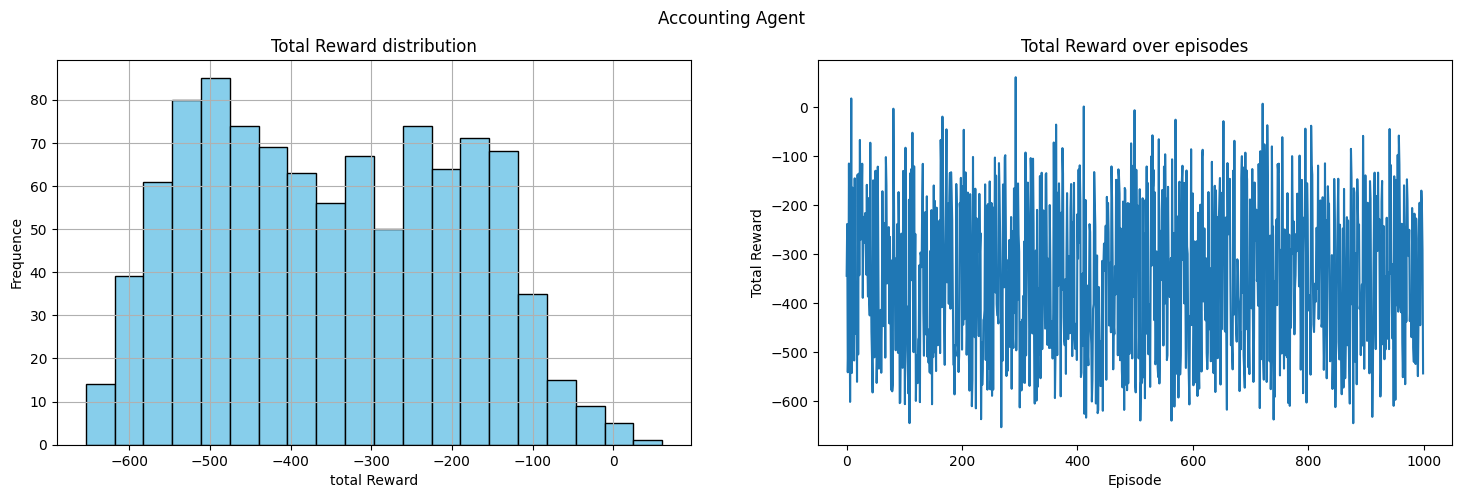

In [16]:
plot_reward(accounting_agent_episode_rewards, "Accounting Agent")

The Accounting Agent shows a distribution of rewards even worse than the Random Agen. This result is due to the purely greedy behavior, which leads the agent to always repeat the action that gave the maximum initial accumulated reward, ignoring other possibilities. This approach does not allow to deal with complex problems such as the Lunar Lander. The Random Agent, while acting randomly, manages to obtain more balanced results.

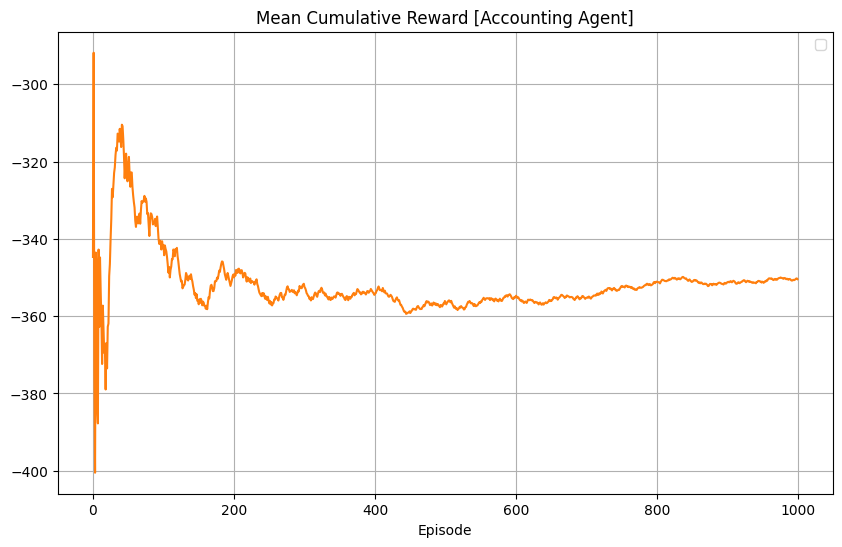

In [17]:
cumulative_average_rewards_accounting = calculate_cumulative_average(accounting_agent_episode_rewards, "Accounting Agent")

# Q-Learning

Next we will develop a basic Q-Learning agent, without using NNs.

The Q-learning approach is one of the most famous RL methods and improves on previous one due to the use of Q-Values, which represent the quality of a specific action in a specific state, following a certain policy. These values are placed in a Q-Table, which is iteratively updated as the agent gains more experience.

A key component to define in this version is the policy $\pi$, this is important as it defines the choices and behaviour of the model, and should balance exploration (of the environment) and exploitation(of already known good-value areas). This is the core of $ϵ$ - greedy policy.


From this point, we have several hyperparameters that we can set. Of course, we didn't fully optimize as it was out of the scope. This section should demonstrate how the algorithm compares to the Random Agent and Accounting Agent. We briefly describe some of the hyperparameters.

* **Learning Rate ($\alpha$ = 0.1)**:
   - It controls how much the Q-values are updated during each learning step.
   - Small values ensures gradual updates, avoiding large oscillations in the Q-value estimates.


* **Discount Factor ($\gamma$ = 0.99)**:
   - It determines how much the agent values future rewards compared to immediate rewards.
   - A value close to 1 makes the agent focus on long-term rewards, it seems to be a good idea here, as the problem requires coordinated actions to land safely.
   - This os a difference with the Accounting Agent, which only cares about immediate accumulated rewards.

* **Initial Exploration Probability ($\epsilon$ = 1.0)**:
   - Starting with a high exploration rate allows the agent to explore the environment in the early stages of training.
   - This ensures the agent does not prematurely settle on suboptimal actions.


* **Epsilon Decay = 0.995**:
   - After the episodes we want the agent to shift its focus on exploitation mostly, to imrpove its solutions.

* **Minimum Exploration Probability ($\epsilon_{min}$ = 0.01)**:
   - It ensures the agent always retains some degree of exploration, even in later episodes.

* **Maximum Number of Steps**
    * Another hyperparameter that affects training.
    * This can be tuned to maximize efficieny and reduce time-wasting, or explore diverse and more complex paths.
    * We set the value to to 500. This encourages the development of strategies that achieve the task quite quickly. This number will be the same for al lthe other models in order to be consistent.

Since the Q-learning algorithm works with discrete states, we discretize the continuous state space into bins.

In [28]:
env = gym.make("LunarLander-v2")

bins = [
    np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20),  # Horizontal Position
    np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20),  # Vertical Position
    np.linspace(env.observation_space.low[2], env.observation_space.high[2], 20),  # Horizontal Speed
    np.linspace(env.observation_space.low[3], env.observation_space.high[3], 20),  # Vertical Speed
    np.linspace(env.observation_space.low[4], env.observation_space.high[4], 20),  # Angle
    np.linspace(env.observation_space.low[5], env.observation_space.high[5], 20),  # Angular Speed
    [0, 0.5, 1],
    [0, 0.5, 1],
]

The discretize_state function converts the continuous state of the Lunar Lander into a discrete state. Each feature is assigned to a bin based on its value, allowing the agent to work with a finite set of states. Each continuous feature of the observation space is divided into 10 bins. This allows the agent to generalize over similar states while maintaining sufficient space for learning.

In [29]:
def discretize_state(state, bins):
    state_idx = []
    for i, val in enumerate(state):
        state_idx.append(np.digitize(val, bins[i]) - 1)
    return tuple(state_idx)


We implement the mentioned $\epsilon$-greedy policy:

- With p=$\epsilon$, the agent chooses a random action (exploration).
- With p=(1 - $\epsilon$), the agent selects the action with the highest Q-value for the current state (exploitation).



In [30]:
def epsilon_greedy_policy(state, q_table, epsilon):
    return env.action_space.sample() if np.random.rand() < epsilon else  np.argmax(q_table[state])

Indeed a policy $\pi$ is none other than a function that returns an action, given a specific state.

In [31]:
def train_q_learning_agent_discrete(env, bins, num_episodes, max_steps, learning_rate, discount_factor, epsilon, epsilon_min, epsilon_decay, log=True):
    state_space_size = tuple(len(b) + 1 for b in bins)
    q_table = np.zeros(state_space_size + (env.action_space.n,))
    rewards = []

    for episode in range(num_episodes):
        obs = env.reset()
        state = discretize_state(obs, bins)
        total_reward = 0

        for step in range(max_steps):
            action = epsilon_greedy_policy(state, q_table, epsilon)
            next_obs, reward, done, _ = env.step(action)
            next_state = discretize_state(next_obs, bins)

            best_next_action = np.argmax(q_table[next_state])
            td_target = reward + discount_factor * q_table[next_state][best_next_action]
            q_table[state][action] += learning_rate * (td_target - q_table[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        #reduce the exploration param
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards.append(total_reward)

        if log and (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}")

    return rewards, q_table

In [32]:
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
max_steps = 500

In [33]:
q_learning_rewards, trained_q_table = train_q_learning_agent_discrete(
    env, bins, 10000, max_steps, learning_rate, discount_factor, epsilon, epsilon_min, epsilon_decay)

Episode 100/10000: Total Reward = -28.02
Episode 200/10000: Total Reward = -393.30
Episode 300/10000: Total Reward = -83.76
Episode 400/10000: Total Reward = -79.40
Episode 500/10000: Total Reward = -7.19
Episode 600/10000: Total Reward = 0.28
Episode 700/10000: Total Reward = -288.95
Episode 800/10000: Total Reward = -240.71
Episode 900/10000: Total Reward = -245.57
Episode 1000/10000: Total Reward = -222.36
Episode 1100/10000: Total Reward = -40.03
Episode 1200/10000: Total Reward = -120.35
Episode 1300/10000: Total Reward = 202.53
Episode 1400/10000: Total Reward = -106.63
Episode 1500/10000: Total Reward = -10.11
Episode 1600/10000: Total Reward = -212.46
Episode 1700/10000: Total Reward = 8.25
Episode 1800/10000: Total Reward = -78.90
Episode 1900/10000: Total Reward = -12.46
Episode 2000/10000: Total Reward = 169.72
Episode 2100/10000: Total Reward = -91.69
Episode 2200/10000: Total Reward = -104.03
Episode 2300/10000: Total Reward = 0.46
Episode 2400/10000: Total Reward = -77.58

Mean Reward: 33.48
Standard Deviation of Reward: 153.21


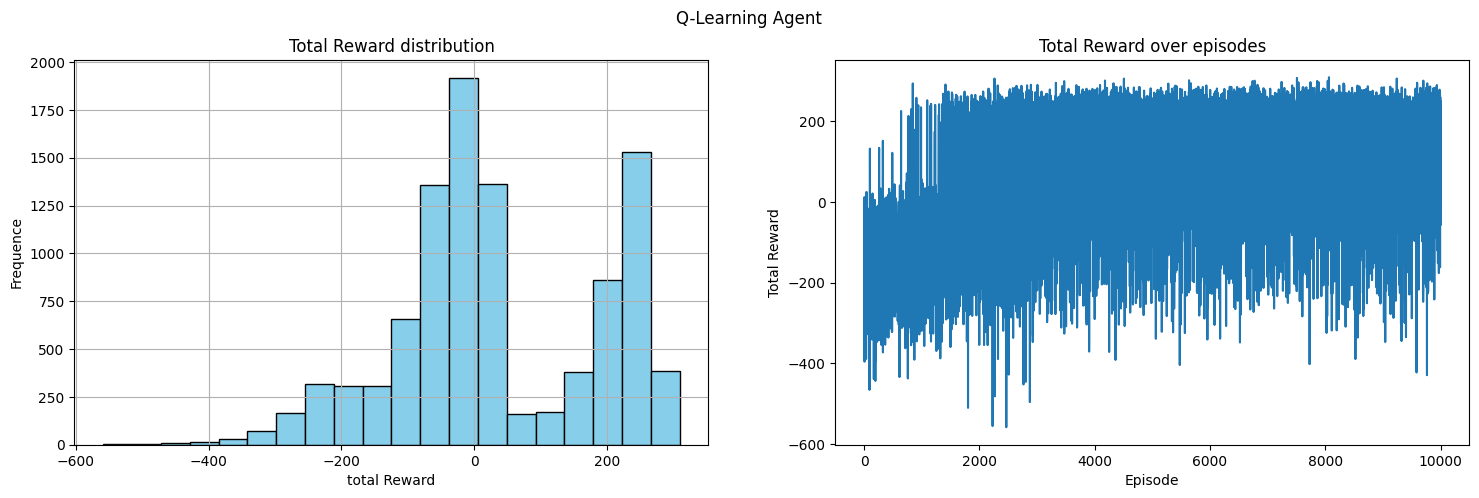

In [34]:
plot_reward(q_learning_rewards, "Q-Learning Agent")

Now we get a significantly higher mean reward, although negative, and while the series is noisy, it seems that the trend is positive.
This suggests that the Q-Learning Agent, although not yet fully optimized, is starting to learn a more effective strategy compared to the other two methods.

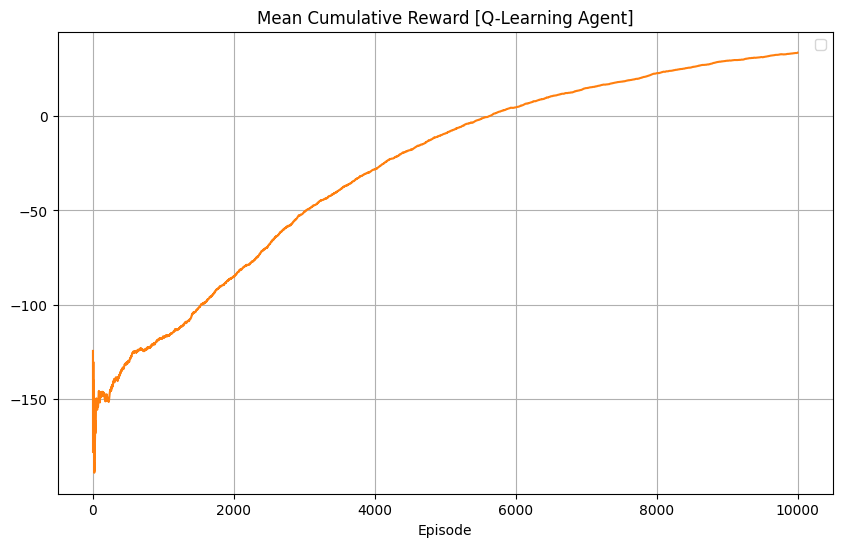

In [35]:
calculate_cumulative_average(q_learning_rewards, "Q-Learning Agent");

The mean cumulative reward is morerealistic, but it's quite nice since it's constantly growing.

Below we show the eEpisode with the biggest reward

In [36]:
def generate_q_learning_video(env, q_table, max_steps):
    frames = []
    state = env.reset()
    state_discrete = discretize_state(state, bins)

    for _ in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        action = np.argmax(q_table[state_discrete])
        state, _, done, _ = env.step(action)
        state_discrete = discretize_state(state, bins)
        if done:
            break

    env.close()
    return frames

video_frames = generate_q_learning_video(env, trained_q_table, max_steps)
create_video(video_frames, "q_learning_video.mp4")

Moviepy - Building video q_learning_video.mp4.
Moviepy - Writing video q_learning_video.mp4



Moviepy - Done !
Moviepy - video ready q_learning_video.mp4


... not as impressive as we thought since that was the best. But we will improve our performance throughout the notebook.

We can try to (not extensively) tune some of the hyperparameters, to do so we test different configurations, with low amount of episodes in a hyperband-fashion. Of course this is not perfect as some combinations may be better than others with longer sequences, but it's needed to do some filtering.

In [37]:
default_learning_rate = 0.1
default_discount_factor = 0.99
default_epsilon = 1.0
default_epsilon_min = 0.01
default_epsilon_decay = 0.995
num_episodes = 2400
num_episodes_prelim = 500
max_steps = 500

In [38]:
configurations = [
    {"learning_rate": 0.1, "discount_factor": 0.99, "epsilon_decay": 0.995},
    {"learning_rate": 0.1, "discount_factor": 0.95, "epsilon_decay": 0.995},
    {"learning_rate": 0.05, "discount_factor": 0.99, "epsilon_decay": 0.99},
    {"learning_rate": 0.2, "discount_factor": 0.9, "epsilon_decay": 0.99},
]

results = []

for config in configurations:
    print(f"Testing configuration: {config}")
    rewards_, _ = train_q_learning_agent_discrete(
        env,
        bins,
        num_episodes=num_episodes_prelim,
        max_steps=max_steps,
        learning_rate=config["learning_rate"],
        discount_factor=config["discount_factor"],
        epsilon=default_epsilon,
        epsilon_min=default_epsilon_min,
        epsilon_decay=config["epsilon_decay"]
    )
    mean_reward, std_reward = np.mean(rewards_), np.std(rewards_)
    results.append({"Config": config, "mean_reward": mean_reward, "std_reward": std_reward})
    print(f"Result: Mean Reward = {mean_reward:.2f}, Std Reward = {std_reward:.2f}\n")


Testing configuration: {'learning_rate': 0.1, 'discount_factor': 0.99, 'epsilon_decay': 0.995}
Episode 100/500: Total Reward = -235.51
Episode 200/500: Total Reward = -66.10
Episode 300/500: Total Reward = -63.95
Episode 400/500: Total Reward = -240.75
Episode 500/500: Total Reward = -116.90
Result: Mean Reward = -142.81, Std Reward = 99.35

Testing configuration: {'learning_rate': 0.1, 'discount_factor': 0.95, 'epsilon_decay': 0.995}
Episode 100/500: Total Reward = -143.71
Episode 200/500: Total Reward = -75.49
Episode 300/500: Total Reward = -133.36
Episode 400/500: Total Reward = -81.18
Episode 500/500: Total Reward = -68.63
Result: Mean Reward = -152.07, Std Reward = 95.49

Testing configuration: {'learning_rate': 0.05, 'discount_factor': 0.99, 'epsilon_decay': 0.99}
Episode 100/500: Total Reward = -185.57
Episode 200/500: Total Reward = -75.91
Episode 300/500: Total Reward = -303.35
Episode 400/500: Total Reward = -96.70
Episode 500/500: Total Reward = -54.44
Result: Mean Reward =

Config 1: {'learning_rate': 0.1, 'discount_factor': 0.99, 'epsilon_decay': 0.995}, Mean Reward = -142.81, Std Reward = 99.35
Config 2: {'learning_rate': 0.1, 'discount_factor': 0.95, 'epsilon_decay': 0.995}, Mean Reward = -152.07, Std Reward = 95.49
Config 3: {'learning_rate': 0.05, 'discount_factor': 0.99, 'epsilon_decay': 0.99}, Mean Reward = -149.13, Std Reward = 97.74
Config 4: {'learning_rate': 0.2, 'discount_factor': 0.9, 'epsilon_decay': 0.99}, Mean Reward = -137.44, Std Reward = 101.89


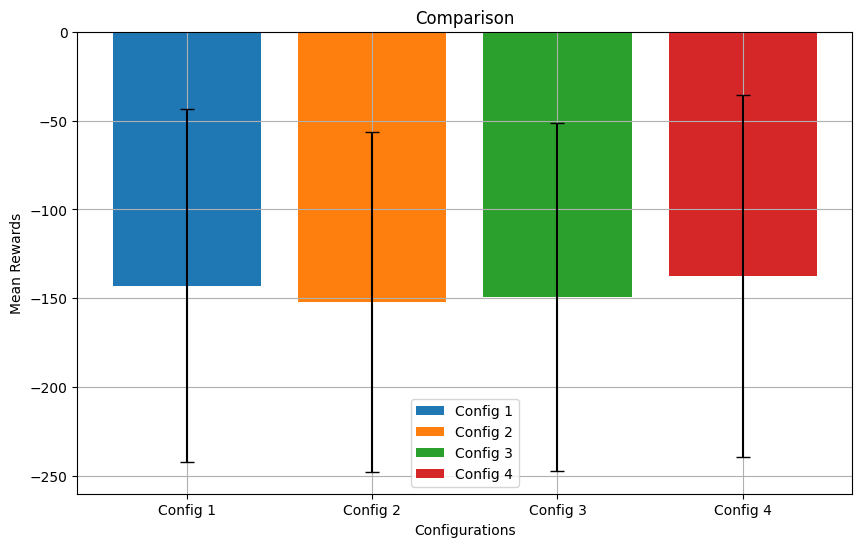

In [39]:
plt.figure(figsize=(10, 6))
for i, result in enumerate(results):
    config = result["Config"]
    plt.bar(i, result["mean_reward"], yerr=result["std_reward"], capsize=5, label=f"Config {i+1}")
    print(f"Config {i+1}: {config}, Mean Reward = {result['mean_reward']:.2f}, Std Reward = {result['std_reward']:.2f}")

plt.title("Comparison")
plt.xlabel("Configurations")
plt.ylabel("Mean Rewards")
plt.xticks(range(len(results)), [f"Config {i+1}" for i in range(len(results))])
plt.legend()
plt.grid();

The barplots of the 4 combinations are quite similar,with also identical error bars.

In [40]:
best_config = max(results, key=lambda x: x["mean_reward"])

print(f"Learning Rate: {best_config['Config']['learning_rate']}")
print(f"Discount Factor: {best_config['Config']['discount_factor']}")
print(f"Epsilon Decay: {best_config['Config']['epsilon_decay']}")
print(f"Mean Reward: {best_config['mean_reward']:.2f}")
print(f"Std Reward: {best_config['std_reward']:.2f}")

Learning Rate: 0.2
Discount Factor: 0.9
Epsilon Decay: 0.99
Mean Reward: -137.44
Std Reward: 101.89


In [42]:
optim_learning_rate = best_config["Config"]["learning_rate"]
optim_discount_factor = best_config["Config"]["discount_factor"]
optim_epsilon_decay = best_config["Config"]["epsilon_decay"]


optim_rewards, optim_q_table = train_q_learning_agent_discrete(
    env, bins, num_episodes=10000, max_steps=max_steps,
    learning_rate=optim_learning_rate, discount_factor=optim_discount_factor,
    epsilon=default_epsilon, epsilon_min=default_epsilon_min, epsilon_decay=optim_epsilon_decay)

Episode 100/10000: Total Reward = -94.81
Episode 200/10000: Total Reward = -72.63
Episode 300/10000: Total Reward = -482.39
Episode 400/10000: Total Reward = -46.72
Episode 500/10000: Total Reward = -137.06
Episode 600/10000: Total Reward = -22.13
Episode 700/10000: Total Reward = 7.95
Episode 800/10000: Total Reward = 7.00
Episode 900/10000: Total Reward = -58.43
Episode 1000/10000: Total Reward = -72.39
Episode 1100/10000: Total Reward = -24.27
Episode 1200/10000: Total Reward = -30.40
Episode 1300/10000: Total Reward = -5.67
Episode 1400/10000: Total Reward = 7.56
Episode 1500/10000: Total Reward = -89.49
Episode 1600/10000: Total Reward = -10.54
Episode 1700/10000: Total Reward = -60.97
Episode 1800/10000: Total Reward = -96.52
Episode 1900/10000: Total Reward = 10.77
Episode 2000/10000: Total Reward = -27.06
Episode 2100/10000: Total Reward = -59.78
Episode 2200/10000: Total Reward = -41.16
Episode 2300/10000: Total Reward = -28.01
Episode 2400/10000: Total Reward = -51.16
Episode

Mean Reward: 28.94
Standard Deviation of Reward: 153.78


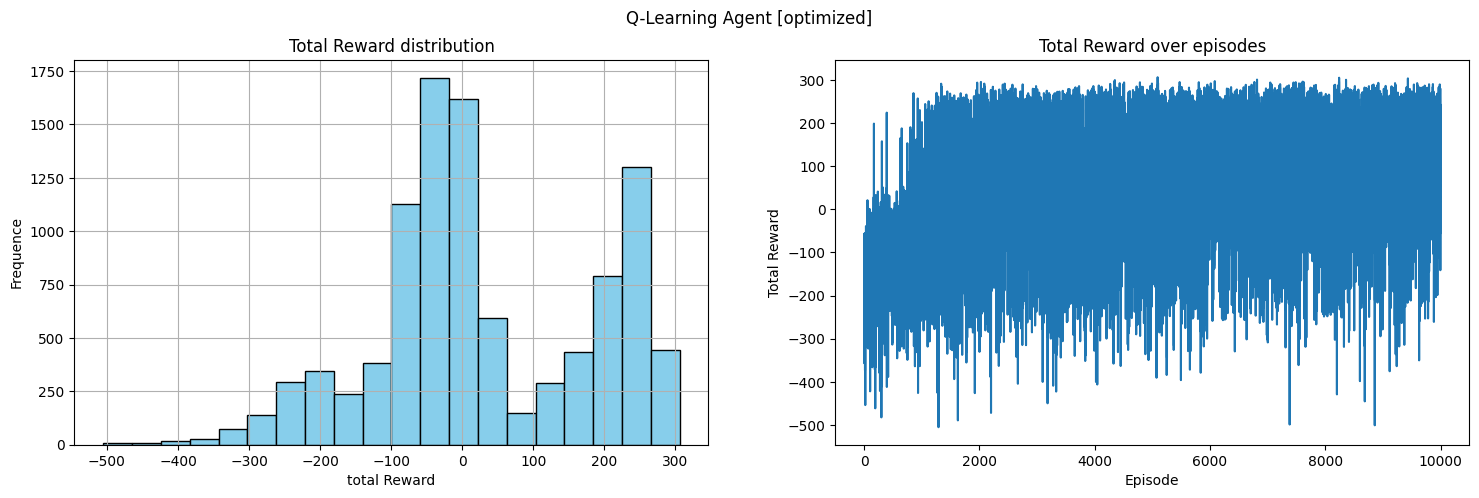

In [43]:
plot_reward(optim_rewards, "Q-Learning Agent [optimized]")

Indeed, we managed to obtain a slightly better agent. Although an increase of 10 in the mean doesn't seem like a lot, it's worth to note that we only tested few combinations.

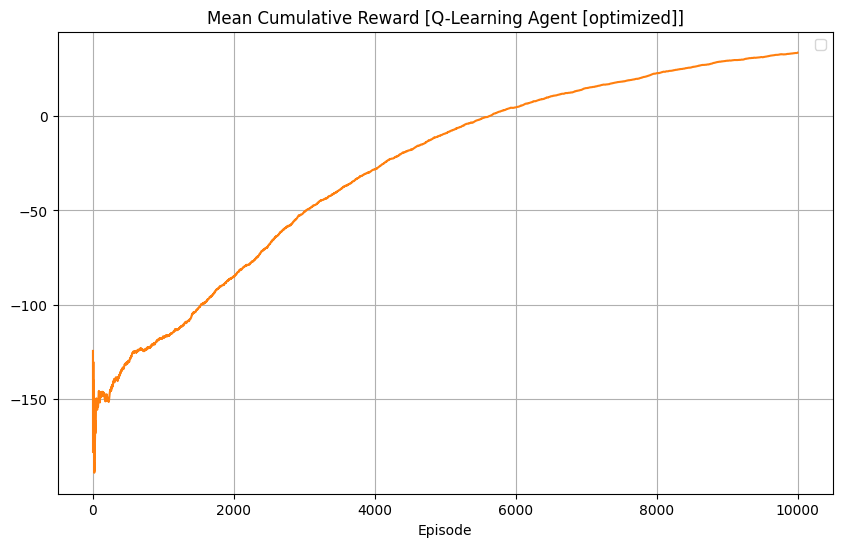

In [44]:
calculate_cumulative_average(q_learning_rewards, "Q-Learning Agent [optimized]");

In [45]:
def evaluate_final_agent(env, q_table, num_episodes=100, max_steps=500):
    rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        state = discretize_state(obs, bins)
        total_reward = 0

        for _ in range(max_steps):
            action = np.argmax(q_table[state])  #  greedy
            next_obs, reward, done, _ = env.step(action)
            total_reward += reward
            state = discretize_state(next_obs, bins)
            if done:
                break

        rewards.append(total_reward)

    return rewards


evaluation_rewards = evaluate_final_agent(env, optim_q_table)
evaluation_mean_reward = np.mean(evaluation_rewards)
evaluation_std_reward = np.std(evaluation_rewards)

print(f"Mean Evaluation Reward: {evaluation_mean_reward:.2f}")
print(f"Standard Deviation of Evaluation Reward: {evaluation_std_reward:.2f}")

Mean Evaluation Reward: 109.45
Standard Deviation of Evaluation Reward: 143.11


In [46]:
video_frames = generate_q_learning_video(env, optim_q_table, max_steps)
create_video(video_frames, "q_learning_video_2.mp4")

Moviepy - Building video q_learning_video_2.mp4.
Moviepy - Writing video q_learning_video_2.mp4



Moviepy - Done !
Moviepy - video ready q_learning_video_2.mp4


The Lander managed to slide closer to the flagged area. We will accept this result, and treat it as a benchmark to compare the deep learning methods.

# Deep Q-Learning

So far we have discretized our space to create an acceptably-sized Q-Table, this is quite limiting as it doesn't fully conveys the characteristics of the environment.
The next step is to remove the Q-Table, and replace it with a Neural Network, that will answer us with the estimated Q-Values, used to find the best action to take at each state.

To create the DQN we will use Pytorch.

The environment is set up, and the key parameters for implementing the DQN are initialized:

The state is now represented as an 8-dimensional vector, while the agent can choose between 4 possible actions.
Some of te hyperparameters are like before: gamma (discount factor), epsilon and epsilon_decay...
Additionally, we add a new concept: Experience Replay: A deque, the Replay BUffer, with a maximum size stores experiences in the form of (state, action, reward, next state, done). The replay buffer is critical for breaking the correlation between sequential experiences, allowing the agent to learn in a more stable and efficient manner by sampling data randomly at each step.

 The batch size is the number of experiences sampled from the replay buffer to update the network.


In [47]:
add_to_replay_buffer = lambda buffer, experience: buffer.append(experience)

sample_from_replay_buffer = lambda buffer, batch_size: random.sample(buffer, batch_size)

In [48]:
replay_buffer = deque(maxlen=100000)

In [49]:
env = gym.make("LunarLander-v2")


state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
gamma = 0.99
learning_rate = 1e-3
num_episodes = 2400
max_steps = 500
batch_size = 64
sync_steps = 100
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
discount_factor = 0.99


replay_buffer = deque(maxlen=100000)


print("Einvinronment configuration done")
print(f"Dimension State: {state_dim}, Dimension action: {action_dim}")

Einvinronment configuration done
Dimension State: 8, Dimension action: 4


We define our DQN as a torch nn.Module.
We tried to keep the NNs quite small, but they still proved to be worthy.

In [50]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In DQL since the Q-Network updates at each step, there are many risks associated with gradient flowing and catastrophic forgetting, to counter this we also define a terget network to estimate the target Q-Value, to then be used as an error meaure.

In [51]:
q_network = DQN(input_dim=state_dim, output_dim=action_dim)
target_network = DQN(input_dim=state_dim, output_dim=action_dim)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
q_network

Exception ignored in: <function b2BodyDef.__del__ at 0x7a53549f3920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/Box2D/Box2D.py", line 2277, in __del__
    self.ClearUserData()
TypeError: in method 'b2BodyDef_ClearUserData', argument 1 of type 'b2BodyDef *'


DQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [52]:
def train_dqn(q_network, target_network, optimizer, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    batch = sample_from_replay_buffer(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = q_network(states).gather(1, actions)

    with torch.no_grad():
        max_next_q_values = target_network(next_states).max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * max_next_q_values * (1 - dones)

    #here we calculate the mse between our network q-values and our other network target ones.
    loss = nn.MSELoss()(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

At a low-frequency rate, we also update the target network.

In [53]:
sync_target_network = lambda q_network, target_network: target_network.load_state_dict(q_network.state_dict())

We create a new $ϵ$-greedy function since we don't have a Q Table from now.

In [54]:
def epsilon_greedy_policy_dqn(env, q_network, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return q_values.argmax().item()

In [55]:
dqn_rewards = []
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = epsilon_greedy_policy_dqn(env, q_network, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        add_to_replay_buffer(replay_buffer, (state, action, reward, next_state, done))

        state = next_state
        train_dqn(q_network, target_network, optimizer, replay_buffer, batch_size, discount_factor)

        if step % sync_steps == 0: #every 100 steps, update target network
            sync_target_network(q_network, target_network)

        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    dqn_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

  4%|▍         | 100/2400 [00:32<17:18,  2.22it/s]

Episode 100/2400: Total Reward = -102.13, Epsilon = 0.606


  8%|▊         | 200/2400 [02:04<34:29,  1.06it/s]

Episode 200/2400: Total Reward = -23.45, Epsilon = 0.367


 12%|█▎        | 300/2400 [04:48<1:15:03,  2.14s/it]

Episode 300/2400: Total Reward = 162.41, Epsilon = 0.222


 17%|█▋        | 400/2400 [08:23<1:17:11,  2.32s/it]

Episode 400/2400: Total Reward = 203.92, Epsilon = 0.135


 21%|██        | 500/2400 [11:32<1:04:27,  2.04s/it]

Episode 500/2400: Total Reward = 245.94, Epsilon = 0.082


 25%|██▌       | 600/2400 [13:50<35:26,  1.18s/it]

Episode 600/2400: Total Reward = 31.90, Epsilon = 0.049


 29%|██▉       | 700/2400 [15:58<29:32,  1.04s/it]

Episode 700/2400: Total Reward = 239.84, Epsilon = 0.030


 33%|███▎      | 800/2400 [18:03<42:47,  1.60s/it]

Episode 800/2400: Total Reward = 271.08, Epsilon = 0.018


 38%|███▊      | 900/2400 [20:09<33:10,  1.33s/it]

Episode 900/2400: Total Reward = 284.03, Epsilon = 0.011


 42%|████▏     | 1000/2400 [22:02<30:33,  1.31s/it]

Episode 1000/2400: Total Reward = 235.90, Epsilon = 0.010


 46%|████▌     | 1100/2400 [23:57<20:12,  1.07it/s]

Episode 1100/2400: Total Reward = 300.46, Epsilon = 0.010


 50%|█████     | 1200/2400 [25:35<20:01,  1.00s/it]

Episode 1200/2400: Total Reward = 247.24, Epsilon = 0.010


 54%|█████▍    | 1300/2400 [27:31<16:43,  1.10it/s]

Episode 1300/2400: Total Reward = 269.07, Epsilon = 0.010


 58%|█████▊    | 1400/2400 [29:30<24:58,  1.50s/it]

Episode 1400/2400: Total Reward = 305.49, Epsilon = 0.010


 62%|██████▎   | 1500/2400 [31:32<20:39,  1.38s/it]

Episode 1500/2400: Total Reward = -150.19, Epsilon = 0.010


 67%|██████▋   | 1600/2400 [33:24<17:00,  1.28s/it]

Episode 1600/2400: Total Reward = 254.90, Epsilon = 0.010


 71%|███████   | 1700/2400 [35:13<11:25,  1.02it/s]

Episode 1700/2400: Total Reward = 278.82, Epsilon = 0.010


 75%|███████▌  | 1800/2400 [37:20<10:06,  1.01s/it]

Episode 1800/2400: Total Reward = 262.77, Epsilon = 0.010


 79%|███████▉  | 1900/2400 [39:07<07:29,  1.11it/s]

Episode 1900/2400: Total Reward = 272.00, Epsilon = 0.010


 83%|████████▎ | 2000/2400 [40:51<07:36,  1.14s/it]

Episode 2000/2400: Total Reward = 249.47, Epsilon = 0.010


 88%|████████▊ | 2100/2400 [42:35<05:06,  1.02s/it]

Episode 2100/2400: Total Reward = 232.90, Epsilon = 0.010


 92%|█████████▏| 2200/2400 [44:30<04:39,  1.40s/it]

Episode 2200/2400: Total Reward = 264.54, Epsilon = 0.010


 96%|█████████▌| 2300/2400 [46:18<01:46,  1.07s/it]

Episode 2300/2400: Total Reward = 261.00, Epsilon = 0.010


100%|██████████| 2400/2400 [48:19<00:00,  1.21s/it]

Episode 2400/2400: Total Reward = 301.51, Epsilon = 0.010


Mean Reward: 176.00
Standard Deviation of Reward: 152.45


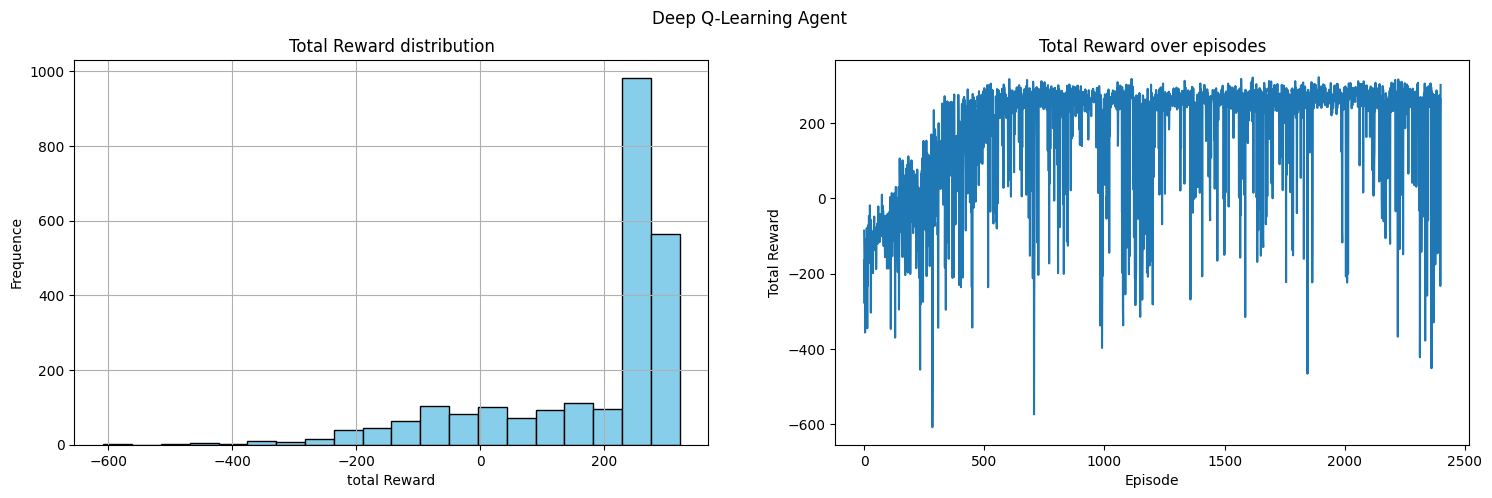

In [56]:
plot_reward(dqn_rewards, "Deep Q-Learning Agent")

Our mean reward is 10 times bigger ! This is very good, the series is also more consitently over 0 and has a few terrible outliers due to exploration.

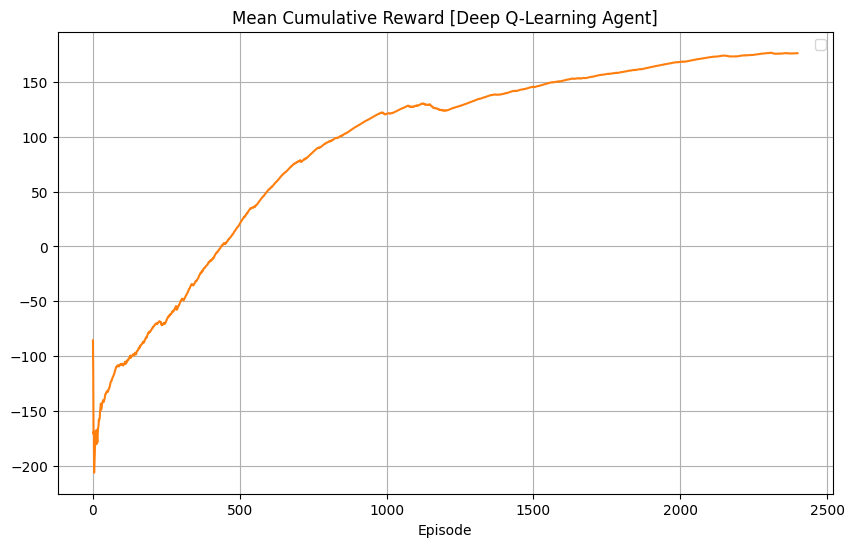

In [57]:
cumulative_average_rewards_dqn = calculate_cumulative_average(dqn_rewards, "Deep Q-Learning Agent")

As we can see the trend is still growing, demonstrating that with more epsiodes we could obtain also better results

In [58]:
def generate_best_episode_video_dqn(env, q_network, rewards, max_steps=500, video_path="best_episode_dqn.mp4"):
    best_episode_index = np.argmax(rewards)
    print(f"Best episode (reward): {best_episode_index + 1} (Reward: {rewards[best_episode_index]:.2f})")

    obs = env.reset()
    frames = []
    done = False

    for step in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action = q_network(obs_tensor).argmax().item()
        obs, _, done, _ = env.step(action)
        if done:
            break

    env.close()

    create_video(frames, video_path)

In [59]:
generate_best_episode_video_dqn(env, q_network, dqn_rewards)

Best episode (reward): 1893 (Reward: 321.93)
Moviepy - Building video best_episode_dqn.mp4.
Moviepy - Writing video best_episode_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_episode_dqn.mp4


This episode wasn't very good, proving that an "higher" reward, doesn't mean that the agent is working completely well.



Here we test our lander with 100 episodes to see how behave eliminating the exploraion and focusing only on reach the objective

In [60]:
def test_dqn_agent(env, q_network, num_test_episodes=100, max_steps=500):
    test_rewards = []

    for episode in range(num_test_episodes):
        obs = env.reset()
        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        for _ in range(max_steps):
            with torch.no_grad():  # greedy withouth exloration
                action = torch.argmax(q_network(state)).item()

            next_obs, reward, done, _ = env.step(action)
            total_reward += reward

            state = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0)
            if done:
                break

        test_rewards.append(total_reward)
    return test_rewards

In [61]:
num_test_episodes = 100
test_rewards = test_dqn_agent(env, q_network, num_test_episodes=num_test_episodes)

Mean Reward: 204.24
Standard Deviation of Reward: 86.16


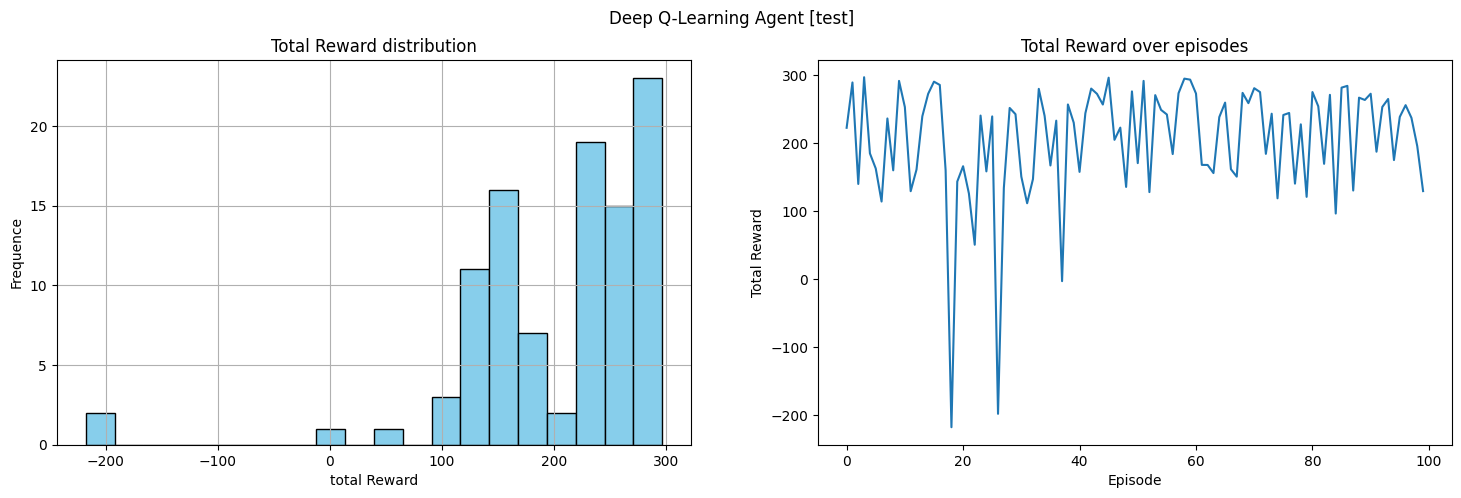

In [62]:
plot_reward(test_rewards, "Deep Q-Learning Agent [test]")

The test distribution is even better.

In [63]:
def generate_best_test_episode_video(env, q_network, test_rewards, max_steps=500):
    best_episode_index = np.argmax(test_rewards)
    print(f"Best test episode (reward):  {best_episode_index + 1} (Reward: {test_rewards[best_episode_index]:.2f})")

    frames = []
    obs = env.reset()
    state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    total_reward = 0

    for step in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        with torch.no_grad():
            action = torch.argmax(q_network(state)).item()

        next_obs, reward, done, _ = env.step(action)
        total_reward += reward
        state = torch.tensor(next_obs, dtype=torch.float32).unsqueeze(0)

        if done:
            break

    env.close()
    print(f"Reward total: {total_reward:.2f}")
    return frames

In [64]:
best_test_episode_frames = generate_best_test_episode_video(env, q_network, test_rewards)

create_video(best_test_episode_frames, "lunar_lander_best_test_episode.mp4")

Best test episode (reward):  4 (Reward: 296.34)
Reward total: 297.69
Moviepy - Building video lunar_lander_best_test_episode.mp4.
Moviepy - Writing video lunar_lander_best_test_episode.mp4



Moviepy - Done !
Moviepy - video ready lunar_lander_best_test_episode.mp4


We consider the simple DQL approach to be quite a success. Next we would like to improve the result while staying in the world of Neural Nets.

# Double Deep Q-Learning

Here we perform Double DQL.

The key difference between DQL and DDQL lies in how the target Q-values are calculated. In DQL, the same target network is used to both select the best action and evaluate its value, which can lead to overestimations. Double DQL fixes this by using the main Q-network to choose the best action and the target network to evaluate the value of that action.

`next_actions = q_network(next_states).argmax(dim=1, keepdim=True)`  
`next_q_values = target_network(next_states).gather(1, next_actions)`

We mantain the same configuration as before to do a better comparison.

In [ ]:
env = gym.make("LunarLander-v2")

replay_buffer = deque(maxlen=100000)

In [ ]:
class DoubleDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DoubleDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
q_network_double = DoubleDQN(input_dim=state_dim, output_dim=action_dim)
target_network_double = DoubleDQN(input_dim=state_dim, output_dim=action_dim)
target_network.load_state_dict(q_network_double.state_dict())

optimizer = optim.Adam(q_network_double.parameters(), lr=learning_rate)
q_network_double

DoubleDQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
def train_double_dqn(q_network, target_network, replay_buffer, batch_size, gamma):
    if len(replay_buffer) < batch_size:
        return

    batch = sample_from_replay_buffer(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)


    q_values = q_network(states).gather(1, actions)

    #indeed, our Q-network to choose the best action
    #and the target network evaluates the value of that action.
    with torch.no_grad():
        next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
        next_q_values = target_network(next_states).gather(1, next_actions)
        targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
double_dqn_rewards = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = epsilon_greedy_policy_dqn(env, q_network_double, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        add_to_replay_buffer(replay_buffer, (state, action, reward, next_state, done))
        state = next_state

        train_double_dqn(q_network_double, target_network_double, replay_buffer, batch_size, gamma)

        if step % sync_steps == 0:
            sync_target_network(q_network_double, target_network_double)

        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    double_dqn_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


  4%|▍         | 100/2400 [00:38<13:06,  2.92it/s]

Episode 100/2400: Total Reward = -79.11, Epsilon = 0.606


  8%|▊         | 200/2400 [02:05<53:55,  1.47s/it]  

Episode 200/2400: Total Reward = -9.36, Epsilon = 0.367


 12%|█▎        | 300/2400 [05:23<1:22:32,  2.36s/it]

Episode 300/2400: Total Reward = 114.06, Epsilon = 0.222


 17%|█▋        | 400/2400 [08:52<1:16:16,  2.29s/it]

Episode 400/2400: Total Reward = 129.11, Epsilon = 0.135


 21%|██        | 500/2400 [11:55<1:07:38,  2.14s/it]

Episode 500/2400: Total Reward = 76.41, Epsilon = 0.082


 25%|██▌       | 600/2400 [14:30<44:00,  1.47s/it]

Episode 600/2400: Total Reward = 239.78, Epsilon = 0.049


 29%|██▉       | 700/2400 [16:40<50:27,  1.78s/it]

Episode 700/2400: Total Reward = 257.86, Epsilon = 0.030


 33%|███▎      | 800/2400 [18:50<29:42,  1.11s/it]

Episode 800/2400: Total Reward = 294.73, Epsilon = 0.018


 38%|███▊      | 900/2400 [20:51<30:34,  1.22s/it]

Episode 900/2400: Total Reward = 211.44, Epsilon = 0.011


 42%|████▏     | 1000/2400 [22:40<22:10,  1.05it/s]

Episode 1000/2400: Total Reward = 264.67, Epsilon = 0.010


 46%|████▌     | 1100/2400 [24:33<21:42,  1.00s/it]

Episode 1100/2400: Total Reward = 258.08, Epsilon = 0.010


 50%|█████     | 1200/2400 [26:23<26:11,  1.31s/it]

Episode 1200/2400: Total Reward = 262.48, Epsilon = 0.010


 54%|█████▍    | 1300/2400 [28:08<28:34,  1.56s/it]

Episode 1300/2400: Total Reward = 162.76, Epsilon = 0.010


 58%|█████▊    | 1400/2400 [29:41<14:36,  1.14it/s]

Episode 1400/2400: Total Reward = 247.57, Epsilon = 0.010


 62%|██████▎   | 1500/2400 [31:35<20:19,  1.36s/it]

Episode 1500/2400: Total Reward = 249.56, Epsilon = 0.010


 67%|██████▋   | 1600/2400 [33:34<10:19,  1.29it/s]

Episode 1600/2400: Total Reward = 286.01, Epsilon = 0.010


 71%|███████   | 1700/2400 [35:08<13:48,  1.18s/it]

Episode 1700/2400: Total Reward = 262.49, Epsilon = 0.010


 75%|███████▌  | 1800/2400 [37:05<10:29,  1.05s/it]

Episode 1800/2400: Total Reward = 276.29, Epsilon = 0.010


 79%|███████▉  | 1900/2400 [38:48<10:30,  1.26s/it]

Episode 1900/2400: Total Reward = -328.54, Epsilon = 0.010


 83%|████████▎ | 2000/2400 [40:53<08:45,  1.31s/it]

Episode 2000/2400: Total Reward = 293.80, Epsilon = 0.010


 88%|████████▊ | 2100/2400 [42:58<06:50,  1.37s/it]

Episode 2100/2400: Total Reward = 271.18, Epsilon = 0.010


 92%|█████████▏| 2200/2400 [44:47<04:15,  1.28s/it]

Episode 2200/2400: Total Reward = 291.26, Epsilon = 0.010


 96%|█████████▌| 2300/2400 [46:41<01:42,  1.02s/it]

Episode 2300/2400: Total Reward = 282.06, Epsilon = 0.010


100%|██████████| 2400/2400 [48:31<00:00,  1.21s/it]

Episode 2400/2400: Total Reward = 262.39, Epsilon = 0.010


Mean Reward: 174.56
Standard Deviation of Reward: 160.50


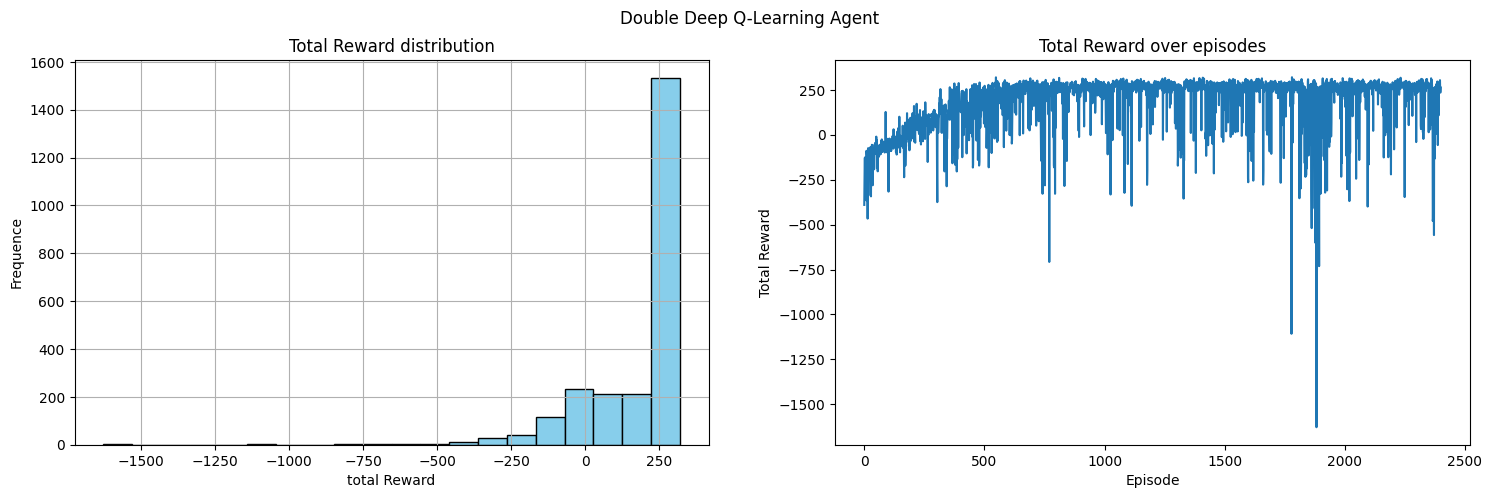

In [ ]:
plot_reward(double_dqn_rewards, "Double Deep Q-Learning Agent")

The performance is significantly better. Now the dustribution as a very significant mode at over 100.

In [ ]:
def generate_best_episode_video_double_dqn(env, q_network, rewards, max_steps=500, video_path="best_episode_double_dqn.mp4"):
    best_episode_index = np.argmax(rewards)
    print(f"Best episode (reward):  {best_episode_index + 1} (Reward: {rewards[best_episode_index]:.2f})")

    obs = env.reset()
    frames = []

    for step in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action = q_network(obs_tensor).argmax().item()
        obs, _, done, _ = env.step(action)
        if done:
            break

    env.close()
    create_video(frames, video_path)

In [ ]:
generate_best_episode_video_double_dqn(env, q_network_double, double_dqn_rewards)

Best episode (reward):  1781 (Reward: 319.53)
Moviepy - Building video best_episode_double_dqn.mp4.
Moviepy - Writing video best_episode_double_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_episode_double_dqn.mp4


This episode looks quite good, although with redundand movements! Close to the result we wanted to obtain.

As before, we test it with 100 episodes to see how it behaves after eliminating exploration.

In [ ]:
double_dqn_test_rewards = test_dqn_agent(env, q_network_double, num_test_episodes=100)

Mean Reward: 150.33
Standard Deviation of Reward: 116.29


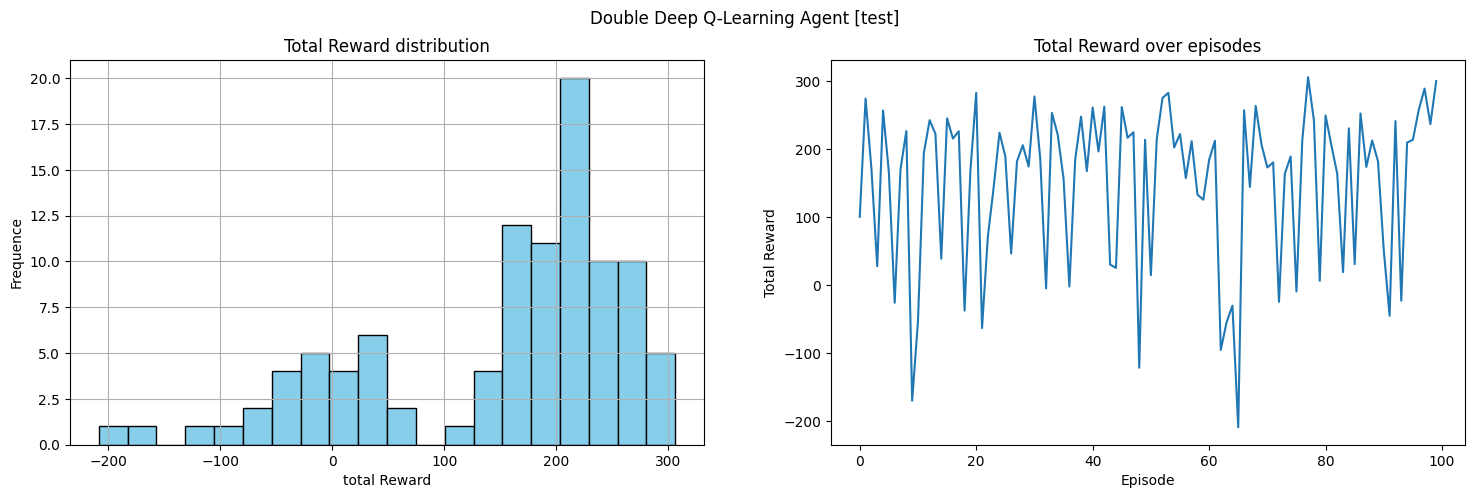

In [ ]:
plot_reward(double_dqn_test_rewards, "Double Deep Q-Learning Agent [test]")

We obtain a mean bigger by 100! And the density is only in the positive half.

In [ ]:
def generate_best_test_episode_video_double_dqn(env, q_network, test_rewards, max_steps=500, video_path="best_test_episode_double_dqn.mp4"):
    best_episode_index = np.argmax(test_rewards)
    print(f"Best test episode (reward):  {best_episode_index + 1} (Reward: {test_rewards[best_episode_index]:.2f})")


    obs = env.reset()
    frames = []

    for step in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action = torch.argmax(q_network(state_tensor)).item()
        obs, _, done, _ = env.step(action)
        if done:
            break

    env.close()
    create_video(frames, video_path)

In [ ]:
generate_best_test_episode_video_double_dqn(env, q_network_double, double_dqn_test_rewards)

Best test episode (reward):  78 (Reward: 306.25)
Moviepy - Building video best_test_episode_double_dqn.mp4.
Moviepy - Writing video best_test_episode_double_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_test_episode_double_dqn.mp4


Similar to before.
In any case it seems that that having large rewards doesn't mean that we have reach the perfect solution. Sometimes there were episodes with very big rewards but the landing was messy with a lot of adjustment before reaching the ground.

Now we look at a compilation of good episode from our DDQN.

Here we define the parameters to define a successful landing: specific thresholds on horizontal position, horizontal velocity, vertical velocity and height.

For the horizontal position (x), it is important that the agent is sufficiently close to the center of the landing platform. It is not enough to accumulate rewards during the flight, but the agent must also reach the designated area to complete the task.

The horizontal velocity (vx) and vertical velocity (vy) are limited to low values ​​to indicate that the agent moves slowly before the contact with the ground. A rapid impact would be penalized in the real world.

The final height (y) must be very close to the ground, as this indicates that the agent has landed successfully. However, it is also combined with constraints on vx and vy to avoid considering as "successes" episodes where the agent simply falls rapidly out of control.

In [ ]:
def collect_top_good_landing_videos(env, q_network, test_rewards, max_steps=500, reward_range=(200, 1000), output_video_path="top_good_landings_combined.mp4", max_videos=10):
    good_landing_indices = [
        i for i, reward in enumerate(test_rewards)
        if reward_range[0] <= reward <= reward_range[1]]


    good_landing_indices = sorted(
        good_landing_indices, key=lambda i: test_rewards[i], reverse=True)

    if not good_landing_indices:
        print(f"No episodes found with rewards in range {reward_range}.")
        return None


    top_landing_indices = good_landing_indices[:max_videos]
    print(f"Selected top {len(top_landing_indices)} episodes for the combined video.")

    video_clips = []
    for idx in top_landing_indices:
        obs = env.reset()
        frames = []
        total_reward = 0

        for step in range(max_steps):
            frames.append(env.render(mode="rgb_array"))
            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = torch.argmax(q_network(state_tensor)).item()
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break


        x, y, vx, vy, _, _, _, _ = obs
        if -0.2 <= x <= 0.2 and abs(vx) < 0.1 and abs(vy) < 0.1 and y < 0.1:

            clip = ImageSequenceClip(frames, fps=30)
            video_clips.append(clip)
            print(f"Episode {idx + 1} added to the combined video (Reward: {test_rewards[idx]:.2f}).")


    if video_clips:
        final_clip = concatenate_videoclips(video_clips, method="compose")
        final_clip.write_videofile(output_video_path, codec="libx264")
        print(f"Combined video saved to: {output_video_path}")
    else:
        print("No valid episodes found for the combined video.")

    return output_video_path if video_clips else None


combined_video_path = collect_top_good_landing_videos(
    env=env,
    q_network=q_network_double,
    test_rewards=double_dqn_test_rewards,
    reward_range=(200, 500),
    output_video_path="top_good_landings_combined_ddqn.mp4",
    max_videos=10
)

display(Video(combined_video_path, embed=True))

Selected top 10 episodes for the combined video.
Episode 78 added to the combined video (Reward: 306.25).
Episode 98 added to the combined video (Reward: 289.53).
Episode 69 added to the combined video (Reward: 264.05).
Episode 43 added to the combined video (Reward: 262.87).
Moviepy - Building video top_good_landings_combined_ddqn.mp4.
Moviepy - Writing video top_good_landings_combined_ddqn.mp4



Moviepy - Done !
Moviepy - video ready top_good_landings_combined_ddqn.mp4
Combined video saved to: top_good_landings_combined_ddqn.mp4


It's good since we didn't optimize the model architecture, nor parameters. In certain runs we obtained much better results.

In [ ]:
from matplotlib.colors import TABLEAU_COLORS

In [ ]:
def compare_models(*model_rewards):
    mods_mean, mods_std = [], []
    for rewards, model_name in model_rewards:
      mod_mean = np.mean(rewards)
      mod_std = np.std(rewards)
      mod_successful_episodes = sum(1 for x in rewards if x >= 200)
      mod_success_rate = mod_successful_episodes / len(rewards) * 100
      mods_mean.append(mod_mean)
      mods_std.append(mod_std)

      print(f"--- {model_name} ---")
      print(f"Mean Reward: {mod_mean:.2f}, Std Dev: {mod_std:.2f}, Success Rate: {mod_success_rate:.2f}%\n")

    labels = [x[1] for x in model_rewards]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, mods_mean, yerr=mods_std, capsize=10, color = list(TABLEAU_COLORS)[:len(model_rewards)], edgecolor='black')
    plt.title("Comparison")
    plt.ylabel("Mean reward")
    plt.grid()

--- DQN ---
Mean Reward: 134.65, Std Dev: 159.83, Success Rate: 50.50%

--- Double DQN ---
Mean Reward: 174.56, Std Dev: 160.50, Success Rate: 66.50%



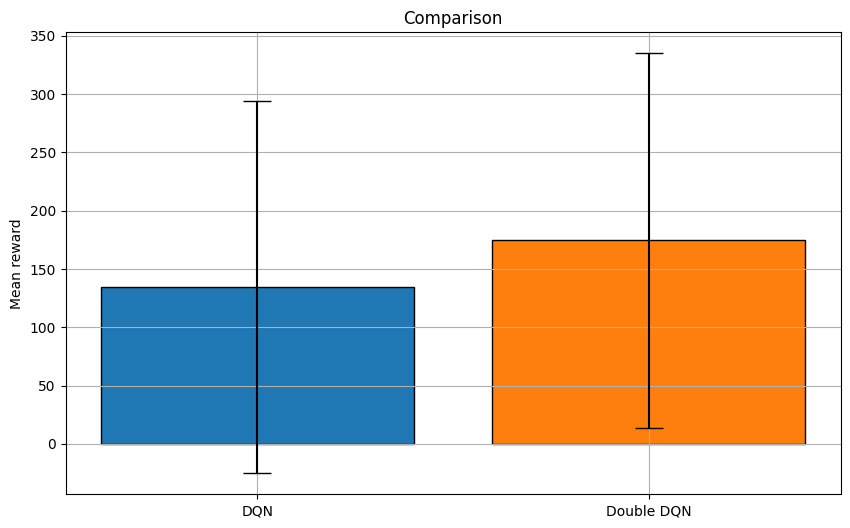

In [ ]:
compare_models((dqn_rewards, "DQN"), (double_dqn_rewards, "Double DQN"))

Quite clearly, the double DQN is a straight up upgrade with a much higher mean and similar variance.

In general, we managed to improve the result with each new version, reaching at the end a satisfying and safe landing.
This showed the potential of Neural Network even in Reinforcement Learning, a field that often used to "do its own thing".

# Dueling Deep Q-Learning

Next, we implement a Dueling DQN.
The change that Dueling DQNs so is that they decompose the Q-Values into two components or streams, the value V of the state, and the advantage A of doing an action in a state (additional value).
The idea is that Q will be represented by a solid baseline, then advantages of each action are added to it, and since the functions are learned by FC layers, they are very flexible.
Q is a sum of the two components, and oten without the mean of the advantages.

The formula of the Q-Values is now:

$$Q(s, a) = V(s) + A(s, a) - \frac{1}{n}\sum^{n}_{a'}{A(s, a')}$$


Note that we are actually implementing a dueling double DQN as we saw that the DDQN had a large improvement from the  DQN.

Compared to the DDQN, here the key change happens in the model itself, not the training process. The network branches into two paths after passing through two dense layers, one is the advantage stream, and the other the value one.

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)

        #the network branches into two fully connected layers, the Value stream (V) and the Advantage stream (A)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values

In [ ]:
env = gym.make("LunarLander-v2")

replay_buffer = deque(maxlen=100000)

In [ ]:
q_network_duel = DuelingDQN(input_dim=state_dim, output_dim=action_dim)
target_network_duel = DuelingDQN(input_dim=state_dim, output_dim=action_dim)

optimizer = optim.Adam(q_network_duel.parameters(), lr=learning_rate)
q_network_duel

DuelingDQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (value_stream): Linear(in_features=128, out_features=1, bias=True)
  (advantage_stream): Linear(in_features=128, out_features=4, bias=True)
)

The next function is really the same as the previous, but we wanted to have one per section.

In [ ]:
def train_dueling_dqn(q_network, target_network, replay_buffer, batch_size, gamma, optimizer):
    if len(replay_buffer) < batch_size:
        return

    batch = sample_from_replay_buffer(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = q_network(states).gather(1, actions)

    #same as ddqn
    with torch.no_grad():
        next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
        next_q_values = target_network(next_states).gather(1, next_actions)
        targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
duel_dqn_rewards = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        action = epsilon_greedy_policy_dqn(env, q_network_duel, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        add_to_replay_buffer(replay_buffer, (state, action, reward, next_state, done))
        state = next_state

        train_dueling_dqn(q_network_duel, target_network_duel, replay_buffer, batch_size, gamma, optimizer)

        if step % sync_steps == 0:
            sync_target_network(q_network_duel, target_network_duel)

        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    duel_dqn_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


  4%|▍         | 100/2400 [02:51<1:35:29,  2.49s/it]

Episode 100/2400: Total Reward = 72.77, Epsilon = 0.010


  8%|▊         | 200/2400 [06:59<1:39:42,  2.72s/it]

Episode 200/2400: Total Reward = 58.11, Epsilon = 0.010


 12%|█▎        | 300/2400 [11:06<33:04,  1.06it/s]

Episode 300/2400: Total Reward = 270.49, Epsilon = 0.010


 17%|█▋        | 400/2400 [13:56<53:32,  1.61s/it]  

Episode 400/2400: Total Reward = 50.61, Epsilon = 0.010


 21%|██        | 500/2400 [16:22<59:51,  1.89s/it]

Episode 500/2400: Total Reward = 238.36, Epsilon = 0.010


 25%|██▌       | 600/2400 [18:34<32:32,  1.08s/it]

Episode 600/2400: Total Reward = 260.76, Epsilon = 0.010


 29%|██▉       | 700/2400 [20:48<36:41,  1.30s/it]

Episode 700/2400: Total Reward = 275.86, Epsilon = 0.010


 33%|███▎      | 800/2400 [22:46<36:10,  1.36s/it]

Episode 800/2400: Total Reward = 273.09, Epsilon = 0.010


 38%|███▊      | 900/2400 [24:34<17:24,  1.44it/s]

Episode 900/2400: Total Reward = -281.71, Epsilon = 0.010


 42%|████▏     | 1000/2400 [26:33<25:44,  1.10s/it]

Episode 1000/2400: Total Reward = 305.18, Epsilon = 0.010


 46%|████▌     | 1100/2400 [28:34<22:16,  1.03s/it]

Episode 1100/2400: Total Reward = 281.31, Epsilon = 0.010


 50%|█████     | 1200/2400 [30:21<22:31,  1.13s/it]

Episode 1200/2400: Total Reward = 280.13, Epsilon = 0.010


 54%|█████▍    | 1300/2400 [32:16<15:45,  1.16it/s]

Episode 1300/2400: Total Reward = -3.93, Epsilon = 0.010


 58%|█████▊    | 1400/2400 [34:07<24:59,  1.50s/it]

Episode 1400/2400: Total Reward = 269.80, Epsilon = 0.010


 62%|██████▎   | 1500/2400 [36:01<14:49,  1.01it/s]

Episode 1500/2400: Total Reward = 257.67, Epsilon = 0.010


 67%|██████▋   | 1600/2400 [37:53<14:26,  1.08s/it]

Episode 1600/2400: Total Reward = 277.65, Epsilon = 0.010


 71%|███████   | 1700/2400 [39:42<13:02,  1.12s/it]

Episode 1700/2400: Total Reward = 284.51, Epsilon = 0.010


 75%|███████▌  | 1800/2400 [41:44<10:02,  1.00s/it]

Episode 1800/2400: Total Reward = 262.48, Epsilon = 0.010


 79%|███████▉  | 1900/2400 [43:46<07:56,  1.05it/s]

Episode 1900/2400: Total Reward = 266.96, Epsilon = 0.010


 83%|████████▎ | 2000/2400 [45:35<07:25,  1.11s/it]

Episode 2000/2400: Total Reward = 258.49, Epsilon = 0.010


 88%|████████▊ | 2100/2400 [47:28<05:05,  1.02s/it]

Episode 2100/2400: Total Reward = 253.99, Epsilon = 0.010


 92%|█████████▏| 2200/2400 [49:22<04:00,  1.20s/it]

Episode 2200/2400: Total Reward = 299.15, Epsilon = 0.010


 96%|█████████▌| 2300/2400 [51:22<01:48,  1.08s/it]

Episode 2300/2400: Total Reward = 255.69, Epsilon = 0.010


100%|██████████| 2400/2400 [53:21<00:00,  1.33s/it]

Episode 2400/2400: Total Reward = 260.51, Epsilon = 0.010


Mean Reward: 219.55
Standard Deviation of Reward: 123.54


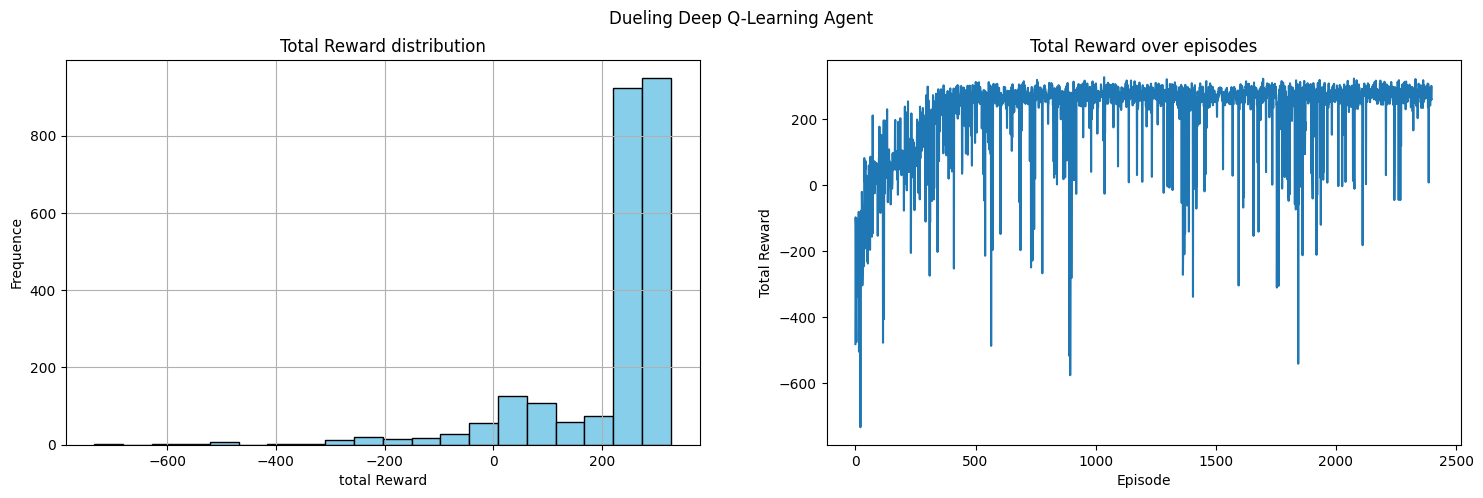

In [ ]:
plot_reward(duel_dqn_rewards, "Dueling Deep Q-Learning Agent")

We managed to further improve the DDQN! Now the mean value is much higher and the standard deviation lower.

In [ ]:
generate_best_episode_video_double_dqn(env, q_network_duel, duel_dqn_rewards, video_path="best_episode_duel_dqn.mp4")

Best episode (reward):  1036 (Reward: 327.08)
Moviepy - Building video best_episode_duel_dqn.mp4.
Moviepy - Writing video best_episode_duel_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_episode_duel_dqn.mp4


Mean Reward: 264.84
Standard Deviation of Reward: 38.19


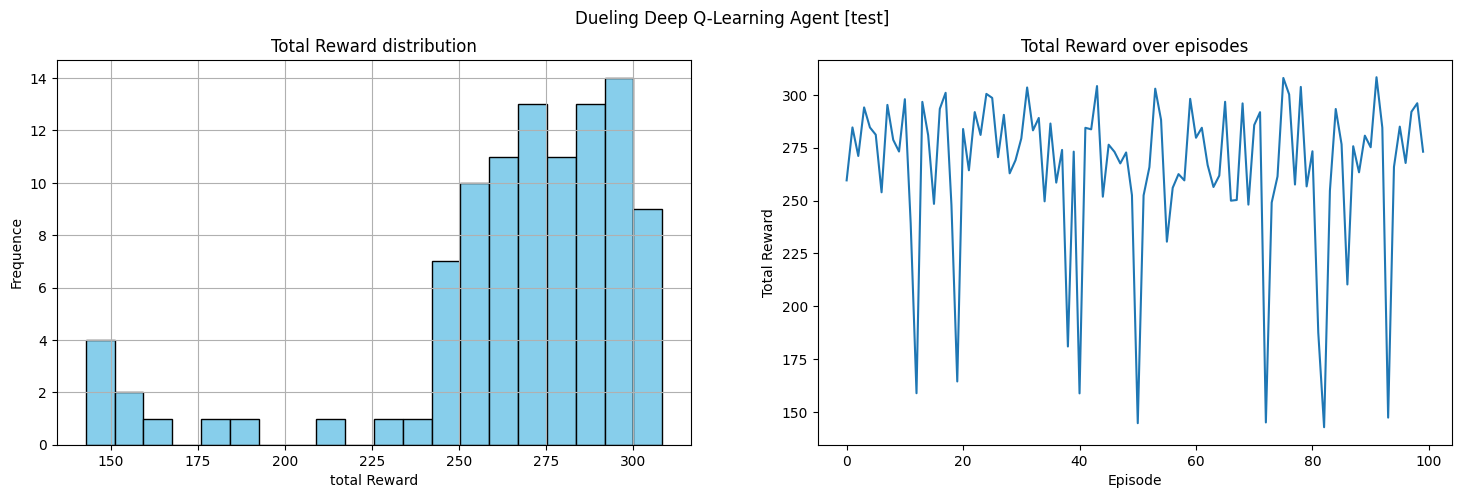

In [ ]:
duel_test_rewards = test_dqn_agent(env, q_network_duel, num_test_episodes=100)
plot_reward(duel_test_rewards, "Dueling Deep Q-Learning Agent [test]")

In [ ]:
generate_best_test_episode_video_double_dqn(env, q_network_duel, duel_test_rewards)

Best test episode (reward):  92 (Reward: 308.30)
Moviepy - Building video best_test_episode_double_dqn.mp4.
Moviepy - Writing video best_test_episode_double_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_test_episode_double_dqn.mp4


# Noisy Deep Q-Learning


Next we try to design a so called Noisy Net.
The big difference is that we don't need to use $\epsilon$-greedy policy, but instead add randomness within the network itself with noisy layers.


In [ ]:
!pip install torchrl
from torchrl.modules import NoisyLinear

The Noisy Linear layer adds parametric noise to the weights. The noise parameters are learnable too.

### Noisy DDQN

In [ ]:
class NoisyDoubleDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NoisyDoubleDQN, self).__init__()
        self.fc1 = NoisyLinear(input_dim, 128)
        self.fc2 = NoisyLinear(128, 128)
        self.fc3 = NoisyLinear(128, output_dim)

    def reset_noise(self):
        self.fc1.reset_noise()
        self.fc2.reset_noise()
        self.fc3.reset_noise()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
replay_buffer = deque(maxlen=100000)
env = gym.make("LunarLander-v2")

In [ ]:
q_network_noisy = NoisyDoubleDQN(input_dim=state_dim, output_dim=action_dim)
target_network_noisy = NoisyDoubleDQN(input_dim=state_dim, output_dim=action_dim)

optimizer = optim.Adam(q_network_noisy.parameters(), lr=learning_rate)
q_network_noisy

NoisyDoubleDQN(
  (fc1): NoisyLinear(in_features=8, out_features=128, bias=True)
  (fc2): NoisyLinear(in_features=128, out_features=128, bias=True)
  (fc3): NoisyLinear(in_features=128, out_features=4, bias=True)
)

In [ ]:
def train_noisy_dqn(q_network, target_network, replay_buffer, batch_size, gamma, optimizer):
    if len(replay_buffer) < batch_size:
        return

    batch = sample_from_replay_buffer(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = q_network(states).gather(1, actions)

    with torch.no_grad():
        next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
        next_q_values = target_network(next_states).gather(1, next_actions)
        targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #we reset noise
    q_network.reset_noise()
    target_network.reset_noise()

In [ ]:
noisy_dqn_rewards = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        with torch.no_grad():
            action = q_network_noisy(torch.tensor(state, dtype=torch.float32)).argmax().item()

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        add_to_replay_buffer(replay_buffer, (state, action, reward, next_state, done))
        state = next_state

        train_noisy_dqn(q_network_noisy, target_network_noisy, replay_buffer, batch_size, gamma, optimizer)

        if step % sync_steps == 0:
            sync_target_network(q_network_noisy, target_network_noisy)

        if done:
            break

    noisy_dqn_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}")

  4%|▍         | 100/2400 [04:08<2:00:58,  3.16s/it]

Episode 100/2400: Total Reward = 39.34


  8%|▊         | 200/2400 [09:43<2:03:03,  3.36s/it]

Episode 200/2400: Total Reward = 48.20


 12%|█▎        | 300/2400 [15:14<2:01:37,  3.47s/it]

Episode 300/2400: Total Reward = 41.99


 17%|█▋        | 400/2400 [19:19<1:00:22,  1.81s/it]

Episode 400/2400: Total Reward = 235.14


 21%|██        | 500/2400 [22:51<1:01:03,  1.93s/it]

Episode 500/2400: Total Reward = 213.43


 25%|██▌       | 600/2400 [26:06<40:20,  1.34s/it]

Episode 600/2400: Total Reward = -6.12


 29%|██▉       | 700/2400 [29:18<50:26,  1.78s/it]

Episode 700/2400: Total Reward = 269.71


 33%|███▎      | 800/2400 [32:23<38:55,  1.46s/it]

Episode 800/2400: Total Reward = 284.13


 38%|███▊      | 900/2400 [36:01<1:11:41,  2.87s/it]

Episode 900/2400: Total Reward = 245.41


 42%|████▏     | 1000/2400 [39:13<48:30,  2.08s/it]

Episode 1000/2400: Total Reward = 245.16


 46%|████▌     | 1100/2400 [42:45<52:49,  2.44s/it]

Episode 1100/2400: Total Reward = 161.03


 50%|█████     | 1200/2400 [45:49<36:18,  1.82s/it]

Episode 1200/2400: Total Reward = 286.32


 54%|█████▍    | 1300/2400 [48:37<26:45,  1.46s/it]

Episode 1300/2400: Total Reward = 264.65


 58%|█████▊    | 1400/2400 [51:10<21:33,  1.29s/it]

Episode 1400/2400: Total Reward = 277.81


 62%|██████▎   | 1500/2400 [53:37<20:06,  1.34s/it]

Episode 1500/2400: Total Reward = 281.45


 67%|██████▋   | 1600/2400 [56:13<24:49,  1.86s/it]

Episode 1600/2400: Total Reward = 277.21


 71%|███████   | 1700/2400 [59:01<13:35,  1.17s/it]

Episode 1700/2400: Total Reward = 277.95


 75%|███████▌  | 1800/2400 [1:01:34<14:37,  1.46s/it]

Episode 1800/2400: Total Reward = 281.93


 79%|███████▉  | 1900/2400 [1:04:04<12:05,  1.45s/it]

Episode 1900/2400: Total Reward = 256.89


 83%|████████▎ | 2000/2400 [1:06:54<12:01,  1.80s/it]

Episode 2000/2400: Total Reward = 298.91


 88%|████████▊ | 2100/2400 [1:09:43<06:47,  1.36s/it]

Episode 2100/2400: Total Reward = 263.31


 92%|█████████▏| 2200/2400 [1:12:36<04:52,  1.46s/it]

Episode 2200/2400: Total Reward = 288.63


 96%|█████████▌| 2300/2400 [1:15:10<02:33,  1.54s/it]

Episode 2300/2400: Total Reward = 270.25


100%|██████████| 2400/2400 [1:17:44<00:00,  1.94s/it]

Episode 2400/2400: Total Reward = 280.37


Mean Reward: 214.57
Standard Deviation of Reward: 120.71


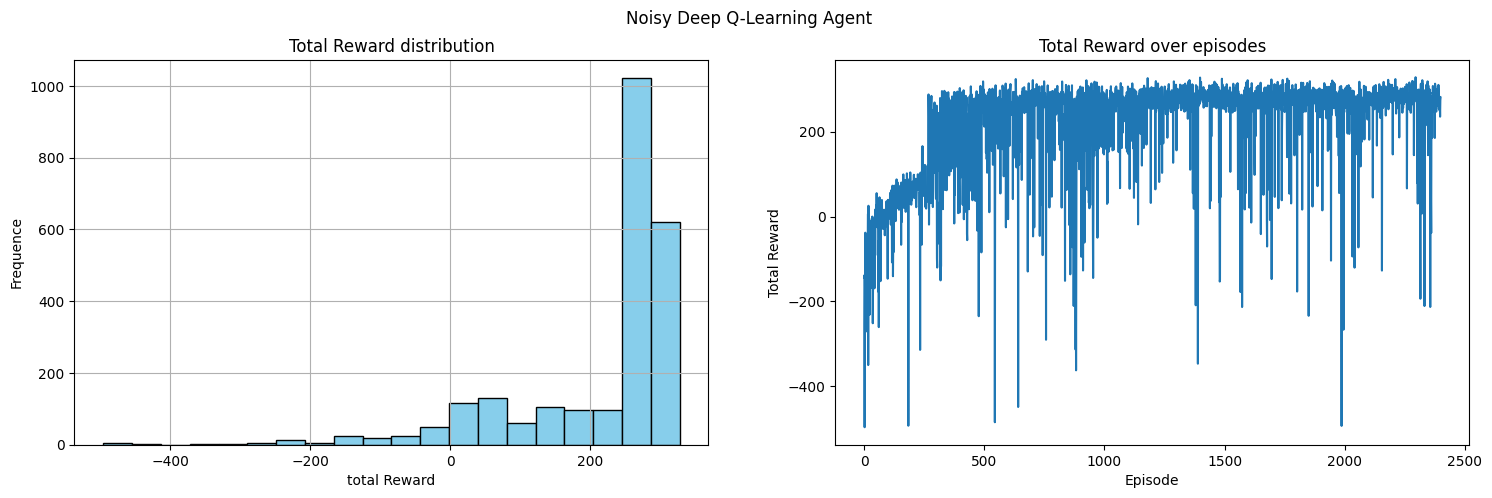

In [ ]:
plot_reward(noisy_dqn_rewards, "Noisy Deep Q-Learning Agent")

This version is a significant improvement from it's $\epsilon$-greedy counterpart (DDQN).


In [ ]:
generate_best_episode_video_double_dqn(env, q_network_noisy, noisy_dqn_rewards, video_path="best_episode_noisy_dqn.mp4")

Best episode (reward):  2296 (Reward: 328.12)
Moviepy - Building video best_episode_noisy_dqn.mp4.
Moviepy - Writing video best_episode_noisy_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_episode_noisy_dqn.mp4


The episode looks perfect.

Mean Reward: 281.66
Standard Deviation of Reward: 34.75


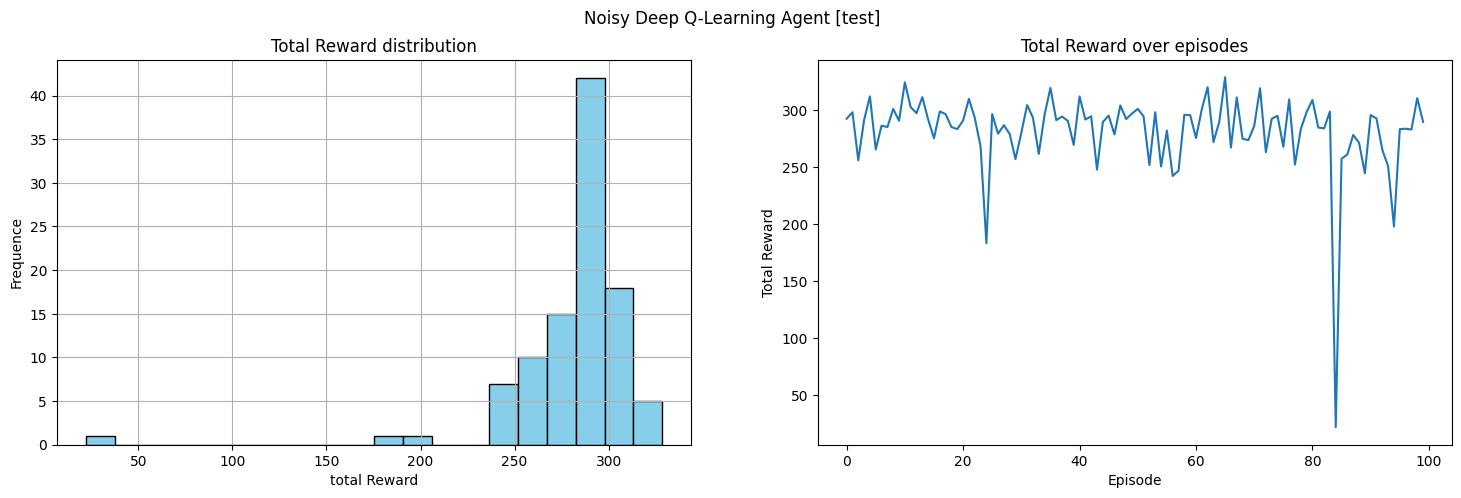

In [ ]:
noisy_test_rewards = test_dqn_agent(env, q_network_noisy, num_test_episodes=100)
plot_reward(noisy_test_rewards, "Noisy Deep Q-Learning Agent [test]")

In [ ]:
generate_best_test_episode_video_double_dqn(env, q_network_noisy, noisy_test_rewards)

Best test episode (reward):  66 (Reward: 328.47)
Moviepy - Building video best_test_episode_double_dqn.mp4.
Moviepy - Writing video best_test_episode_double_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_test_episode_double_dqn.mp4


### Noisy Dueling DDQN

Since the Dueling DDQN was much better than the DDQN, and the Noisy Net was too, we will try to merge the two.  

In [ ]:
class NoisyDuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NoisyDuelingDQN, self).__init__()
        self.fc1 = NoisyLinear(input_dim, 128)
        self.fc2 = NoisyLinear(128, 128)

        self.value_stream = NoisyLinear(128, 1)

        self.advantage_stream = NoisyLinear(128, output_dim)

    def reset_noise(self):
        self.fc1.reset_noise()
        self.fc2.reset_noise()
        self.value_stream.reset_noise()
        self.advantage_stream.reset_noise()


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values

In [ ]:
replay_buffer = deque(maxlen=100000)
env = gym.make("LunarLander-v2")

In [ ]:
q_network_noisy_duel = NoisyDuelingDQN(input_dim=state_dim, output_dim=action_dim)
target_network_noisy_duel = NoisyDuelingDQN(input_dim=state_dim, output_dim=action_dim)

optimizer = optim.Adam(q_network_noisy_duel.parameters(), lr=learning_rate)
q_network_noisy_duel

NoisyDuelingDQN(
  (fc1): NoisyLinear(in_features=8, out_features=128, bias=True)
  (fc2): NoisyLinear(in_features=128, out_features=128, bias=True)
  (value_stream): NoisyLinear(in_features=128, out_features=1, bias=True)
  (advantage_stream): NoisyLinear(in_features=128, out_features=4, bias=True)
)

In [ ]:
noisy_duel_dqn_rewards = []

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):

        with torch.no_grad():
            action = q_network_noisy_duel(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        add_to_replay_buffer(replay_buffer, (state, action, reward, next_state, done))
        state = next_state

        train_noisy_dqn(q_network_noisy_duel, target_network_noisy_duel, replay_buffer, batch_size, gamma, optimizer)

        if step % sync_steps == 0:
            sync_target_network(q_network_noisy_duel, target_network_noisy_duel)

        if done:
            break

    noisy_duel_dqn_rewards.append(total_reward)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes}: Total Reward = {total_reward:.2f}")

  4%|▍         | 100/2400 [05:12<1:56:37,  3.04s/it]

Episode 100/2400: Total Reward = 72.52


  8%|▊         | 200/2400 [11:42<2:25:21,  3.96s/it]

Episode 200/2400: Total Reward = 47.43


 12%|█▎        | 300/2400 [18:08<2:04:58,  3.57s/it]

Episode 300/2400: Total Reward = 104.56


 17%|█▋        | 400/2400 [23:15<1:45:46,  3.17s/it]

Episode 400/2400: Total Reward = 143.20


 21%|██        | 500/2400 [27:55<1:31:51,  2.90s/it]

Episode 500/2400: Total Reward = 170.82


 25%|██▌       | 600/2400 [31:43<52:25,  1.75s/it]

Episode 600/2400: Total Reward = 257.46


 29%|██▉       | 700/2400 [35:19<52:04,  1.84s/it]

Episode 700/2400: Total Reward = 287.98


 33%|███▎      | 800/2400 [38:45<1:07:38,  2.54s/it]

Episode 800/2400: Total Reward = 282.51


 38%|███▊      | 900/2400 [42:22<51:43,  2.07s/it]

Episode 900/2400: Total Reward = 302.60


 42%|████▏     | 1000/2400 [45:51<46:21,  1.99s/it]

Episode 1000/2400: Total Reward = 301.64


 46%|████▌     | 1100/2400 [48:49<40:50,  1.88s/it]

Episode 1100/2400: Total Reward = 255.37


 50%|█████     | 1200/2400 [51:50<27:43,  1.39s/it]

Episode 1200/2400: Total Reward = 8.61


 54%|█████▍    | 1300/2400 [54:58<26:38,  1.45s/it]

Episode 1300/2400: Total Reward = 268.27


 58%|█████▊    | 1400/2400 [57:51<25:04,  1.50s/it]

Episode 1400/2400: Total Reward = 293.26


 62%|██████▎   | 1500/2400 [1:00:27<26:27,  1.76s/it]

Episode 1500/2400: Total Reward = 289.08


 67%|██████▋   | 1600/2400 [1:03:27<18:05,  1.36s/it]

Episode 1600/2400: Total Reward = 290.83


 71%|███████   | 1700/2400 [1:06:24<20:06,  1.72s/it]

Episode 1700/2400: Total Reward = 288.56


 75%|███████▌  | 1800/2400 [1:09:11<18:36,  1.86s/it]

Episode 1800/2400: Total Reward = 294.14


 79%|███████▉  | 1900/2400 [1:11:54<11:34,  1.39s/it]

Episode 1900/2400: Total Reward = 291.68


 83%|████████▎ | 2000/2400 [1:14:51<11:35,  1.74s/it]

Episode 2000/2400: Total Reward = 277.84


 88%|████████▊ | 2100/2400 [1:17:54<08:15,  1.65s/it]

Episode 2100/2400: Total Reward = 273.82


 92%|█████████▏| 2200/2400 [1:20:51<05:04,  1.52s/it]

Episode 2200/2400: Total Reward = 272.21


 96%|█████████▌| 2300/2400 [1:23:45<02:28,  1.49s/it]

Episode 2300/2400: Total Reward = 304.71


100%|██████████| 2400/2400 [1:26:51<00:00,  2.17s/it]

Episode 2400/2400: Total Reward = 167.86


Mean Reward: 214.88
Standard Deviation of Reward: 116.85


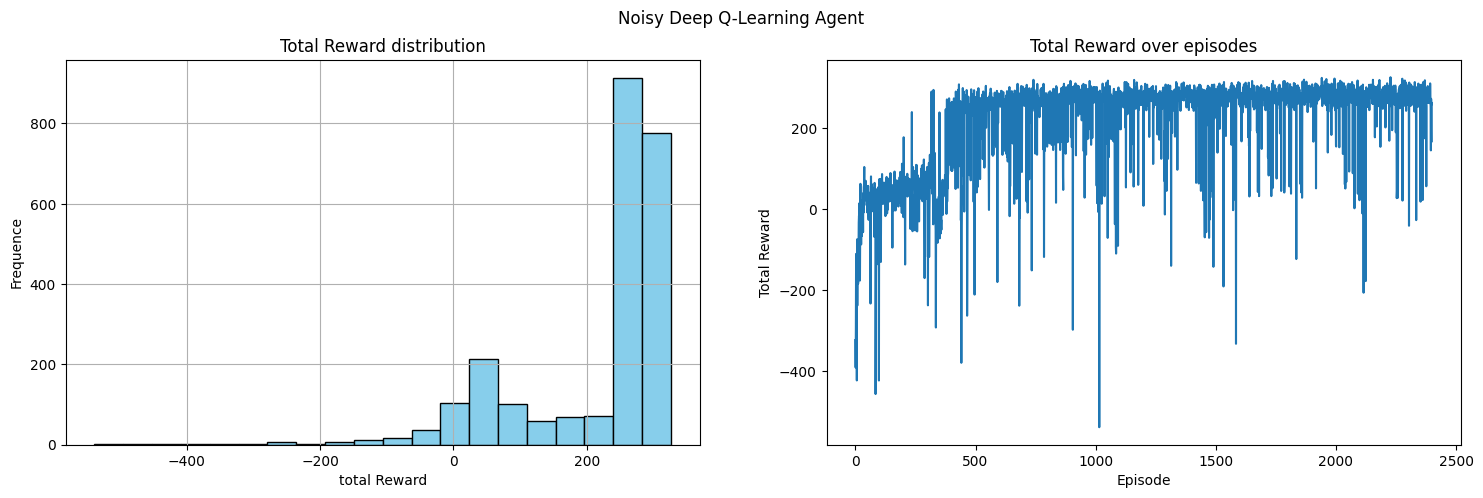

In [ ]:
plot_reward(noisy_duel_dqn_rewards, "Noisy Deep Q-Learning Agent")

The performance is equivalent to the non-dueling version.

In [ ]:
generate_best_episode_video_double_dqn(env, q_network_noisy_duel, noisy_duel_dqn_rewards, video_path="best_episode_noisy_duel_dqn.mp4")

Best episode (reward):  2228 (Reward: 326.12)
Moviepy - Building video best_episode_noisy_duel_dqn.mp4.
Moviepy - Writing video best_episode_noisy_duel_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_episode_noisy_duel_dqn.mp4


Mean Reward: 265.51
Standard Deviation of Reward: 47.84


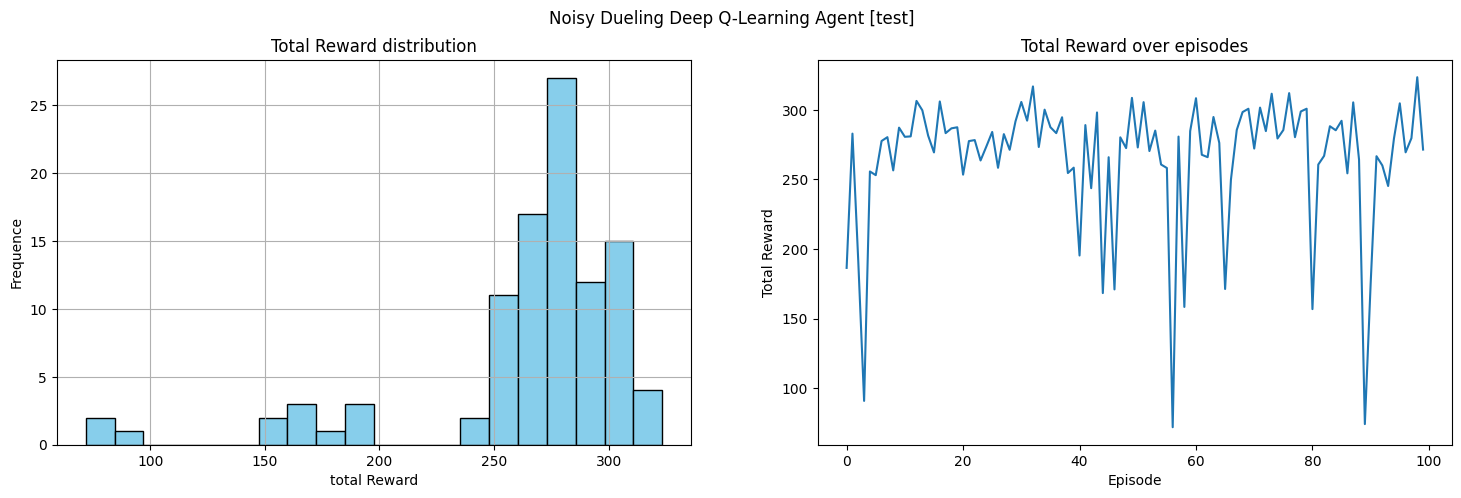

In [ ]:
noisy_duel_test_rewards = test_dqn_agent(env, q_network_noisy_duel, num_test_episodes=100)
plot_reward(noisy_duel_test_rewards, "Noisy Dueling Deep Q-Learning Agent [test]")

In [ ]:
generate_best_test_episode_video_double_dqn(env, q_network_noisy_duel, noisy_duel_test_rewards)

Best test episode (reward):  99 (Reward: 323.39)
Moviepy - Building video best_test_episode_double_dqn.mp4.
Moviepy - Writing video best_test_episode_double_dqn.mp4



Moviepy - Done !
Moviepy - video ready best_test_episode_double_dqn.mp4


This is our most complex agent.
Since it's a (1) Double, (2) Dueling, (3) Noisy model, it's effectively an... Half-Rainbow DQN.

# Comparison

--- DQN ---
Mean Reward: 134.65, Std Dev: 159.83, Success Rate: 50.50%

--- Double DQN ---
Mean Reward: 174.56, Std Dev: 160.50, Success Rate: 66.50%

--- Dueling DQN ---
Mean Reward: 219.55, Std Dev: 123.54, Success Rate: 79.25%

--- Noisy DQN ---
Mean Reward: 214.57, Std Dev: 120.71, Success Rate: 72.58%

--- Noisy Dueling DQN ---
Mean Reward: 214.88, Std Dev: 116.85, Success Rate: 73.08%



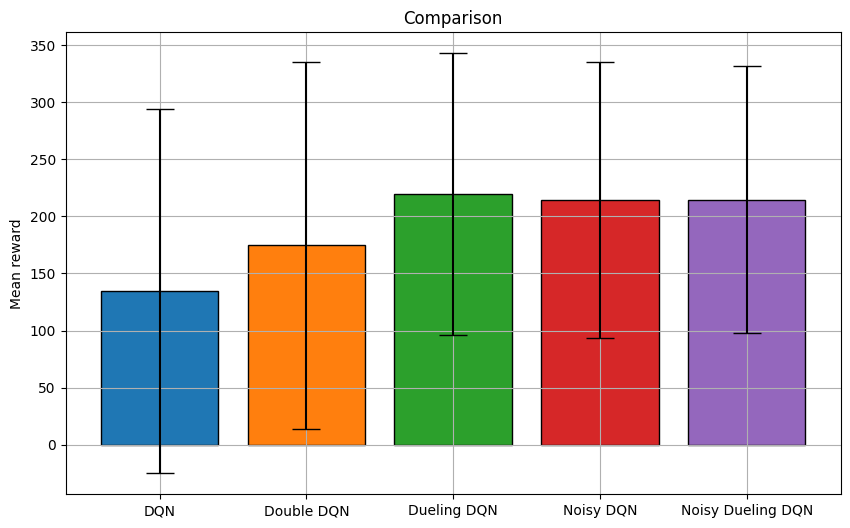

In [ ]:
compare_models((dqn_rewards, "DQN"), (double_dqn_rewards, "Double DQN"), (duel_dqn_rewards, "Dueling DQN"), (noisy_dqn_rewards, "Noisy DQN"), (noisy_duel_dqn_rewards, "Noisy Dueling DQN"))

We see that every alternative version is an improvement to default DQN. Dueling, Noisy and Noisy Dueling are very similar, with Dueling being the best one due to a particularly lucky run. Earlier, the Noisy bersions both beat it.

In [ ]:
torch.save(q_network_duel.state_dict(), "duel_q.pt")
torch.save(target_network_duel.state_dict(), "duel_target.pt")

In [ ]:
torch.save(q_network_noisy_duel.state_dict(), "noisy_duel_q.pt")
torch.save(target_network_noisy_duel.state_dict(), "noisy_duel_target.pt")